In [170]:
#import modules
#standard libraries
import numpy as np
import statistics
import itertools
from IPython.display import display, clear_output

#learning and evalution modules
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#signal analysis
from scipy import signal
from scipy.io import wavfile
import librosa

#plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize


### Motivation

**Background**: Robots are equipped with a variety of sensors that allow them to interact with objects in there surroundings and that help inform higher-level control and planning decison-making. In general, there are two major sensing modalities for robots: vision-based and tactile-based. Vision-based sensors rely on cameras and ranging instruments to directly visualize the robot's environment and localize landmarks (e.g. tags, markers). Cameras may be placed on the robot itself or they can be externally mounted. One of the main drawbacks of cameras and ranging instruments is that they suffer from occlusions. Another issue is that processing point-clouds and images (e.g. for feature extraction and object detection) can be challenging, especially in the presence of varying lighting and shadows. In contrast to vision-based sensors, tactile sensors gather information from physical interactions with objects. Tactile sensors are usually directly mounted to the 'probing' components of the robot (e.g. hand of a robotic manipulator or the wheel of a mobile robot). A common architecture for tactile sensors involves a network of piezo-resistive, capacitive, optical or electromagnetic elements that detect different characteristics of physical interactions (e.g. force, proximity, angle of contact). Recently, tactile sensors based on acoustics have been developed. Acoustic-based tactile sensors have been used for contact localization, force characterization and slip detection. Recently, research groups have explored using vibrations generated by the interaction of a robotic hand with different objects to make predictions about the properties of those objects (e.g. texture, hardness). 

**Problem Description**: In this project, I ask the question, *can vibration data, acquired using contact microphones and resulting from the interaction of a robotic hand engaging in exploratory actions with objects, be used to identify these objects*.

**Signficance**: Acoustic-based tactile sensors are an intriguing addition to the sensing toolkit of robots since they allow for low-density sensor networks with capabilities such as contact localization and object classification. Real-time object classification can enable robots to tailor their interactions and can help inform task planning (e.g. sorting, pick and place) in environments where cameras fail due to occlusions. Developing an algorithm that can clasify objects in real-time based on vibration data is a critical step in the development pipeiline of acoustic-tactile sensors.

**Dataset**: The dataset consists of vibration data from a robotic hand engaging in exploratory actions with different objects (I will discuss specifics about the objects in the next section). In each trial, a robotic hand grabs and object and rubs it on a serrated, wooden stick. As seen in **Fig. 1**, several contact microphones are used to acquire vibration data from the interaction of the robotic hand with the object and the stick. In the next section, I will discuss which contact microphones I will use to classify the objects in the dataset.

![fig_1](images/setup.png)

**Figure 1:** Setup of the experiment used to acquire the acoustic/vibration data including a robotic hand, a serrated wooden stick on which the objects are rubbed and the contact microphones (two on the robot itself and two on the serrated stick).

**Solution Approach/Technique**: Different approaches have been used to classify objects using acoustic/vibration data acquired in a variety of setups (e.g. from robotic hands, scanning probes or grippers manipulating objects and materials with different textures and surface characteristics). The most common approaches are listed below:
1. Convolutional neural networks (CNNs) can be used to interpret 1D data (acoustic time-series) or 2D data (spectrograms)
2. Regression algorithms (e.g. SVM, k-NN) are often used to interet frequency-domain descriptions of acoustic data
3. Transformers (paired with a CNN) have been used to interpret frequency-domain descriptions of acoustic data



The problem is described clearly so that a technical-non expert can understand it. Its importance in engineering (industry or science) is well-explained, and appropriate sources are given. The choice of technique for the problem is well-justified.



### Objects in Dataset
We first show all the objects in the dataset. Visually we recognize that some of these objects have a similar texture and so classification using contact microphone data may not always work.

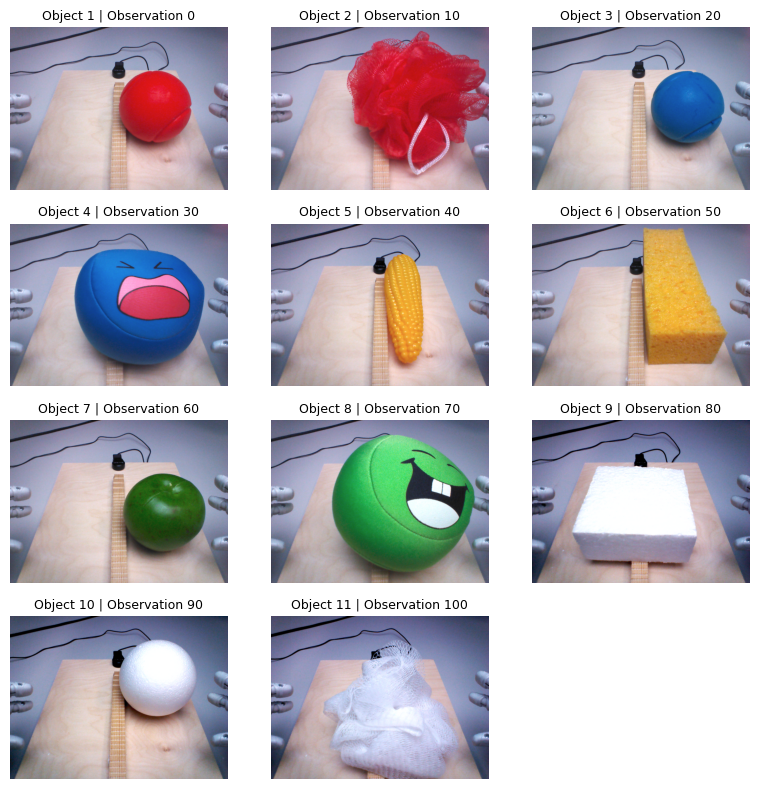

In [99]:
#plot the objects in the dataset
num_rows = 4
num_cols = 3
total_images = num_rows * num_cols
objects = 11

#create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8,8))  # Adjust figsize accordingly

#initialize a counter for the image index
idx = 0

#iterate through the subdirectories
for object_num in range(1, objects + 1):
    run_ideal_num = 0
    run_ideal_num += 10 * (object_num - 1)
    image_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/foreground.png'
    img = mpimg.imread(image_path)
    i, j = divmod(idx, num_cols)
    axes[i, j].imshow(img)
    axes[i, j].set_title(f'Object {object_num} | Observation {run_ideal_num}', fontsize=9)
    axes[i, j].axis('off')
    idx += 1

fig.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

### Data Processing
Several processing steps are usually performed on time-series data. These include:
- De-noising by spectral noise subtraction*
- Data normalization to zero mean and unit standard deviation

*I will make use of the de-noised versions of each time-series which are included in the dataset.

In [25]:
def audio_normalization(y: np.array):
    #scale audio data to zero mean and unit standard deviation
    ys = np.zeros(y.shape)
    m = np.mean(y)
    std = np.std(y)
    ys = (y - m) / std

    return ys

In [26]:
def audio_extraction(file_path, channel, scaling=False):
    #convert .wav file to array of amplitudes
    sampling_freq, audio = wavfile.read(file_path)
    audio = np.array(audio[:, channel])
    audio = audio.astype(np.float64)

    if scaling == True:
        audio = audio_normalization(audio)

    return sampling_freq, audio

### Inital Analysis of Data
We first analyze the data to see if there are visually perceptible difference in the audio for each object. To do this we compare the raw audio, Mel spectrograms and the Mel frequency cepstral coefficients (MFCCs) for the audio acquired for a given experiment on each object.

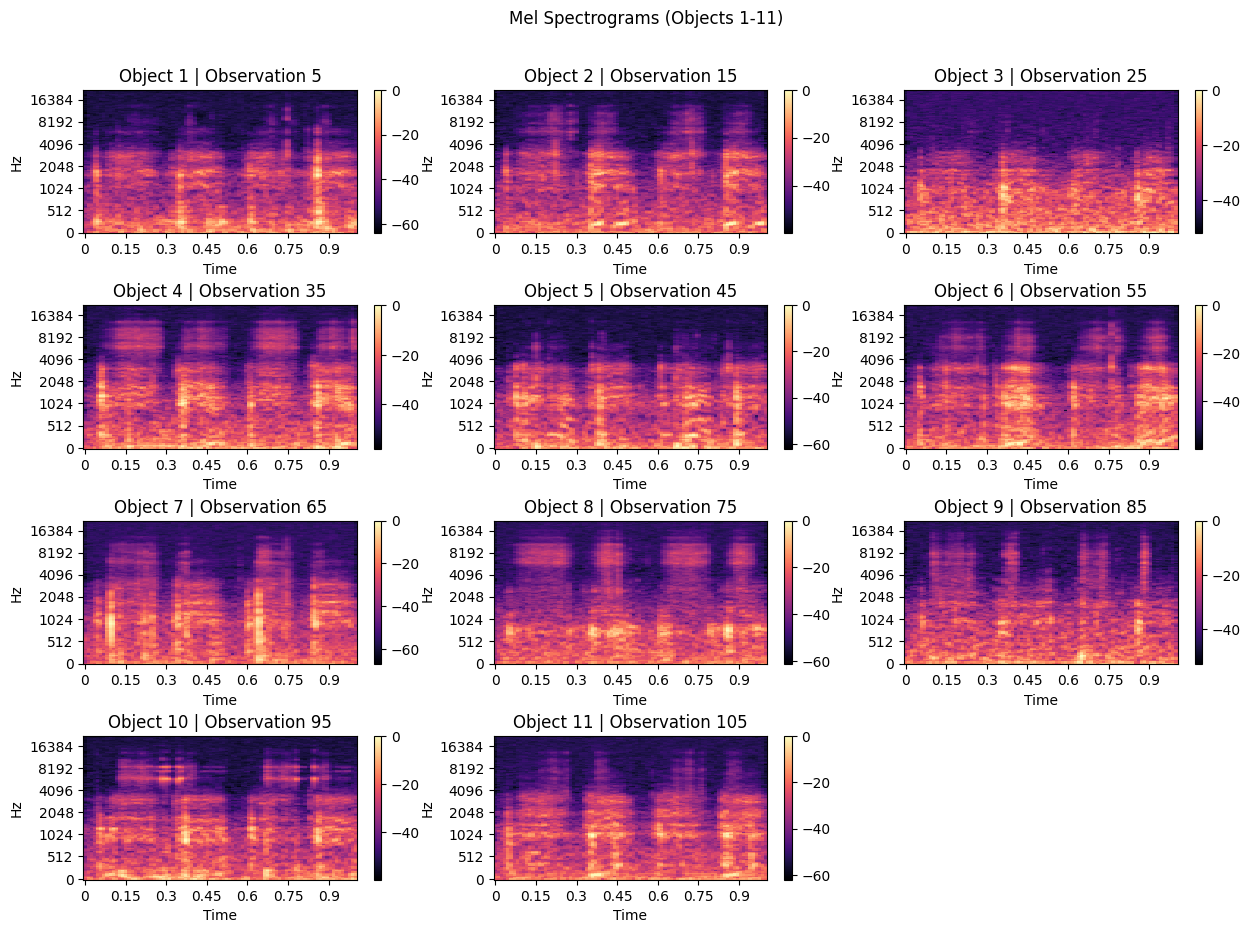

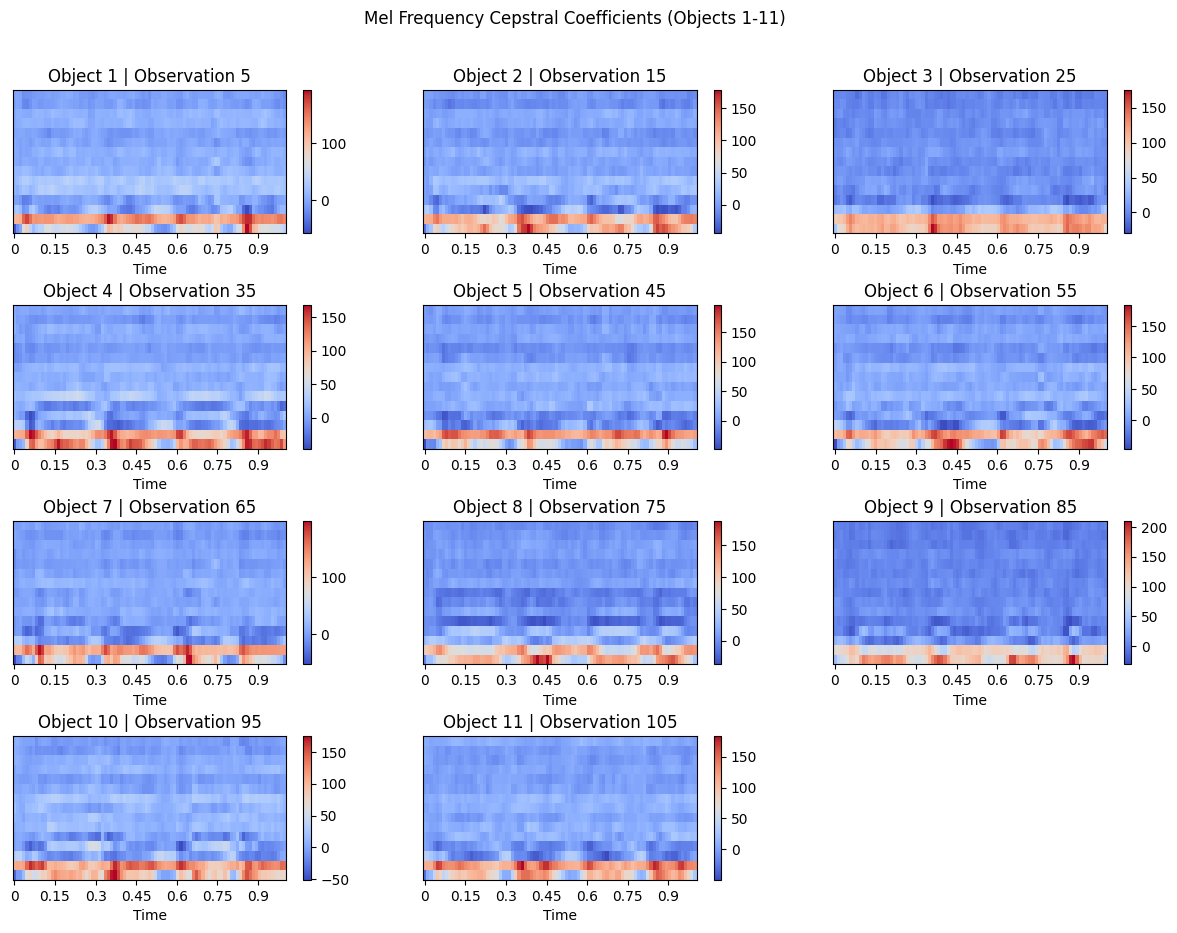

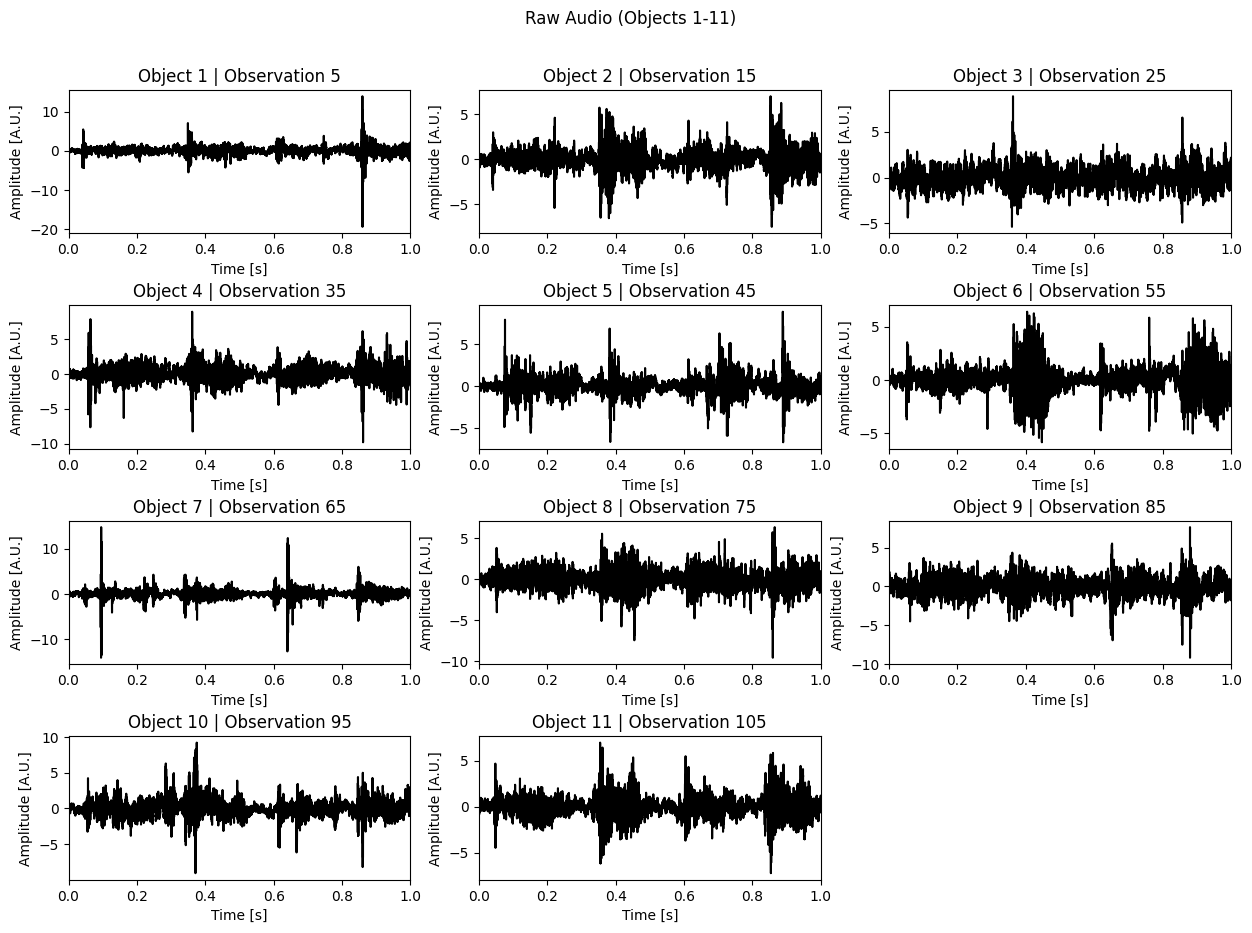

In [101]:
#extract the raw signal, MFCC components and Mel spectrograms for each object
#dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
channel = 0            #channel to read data from
objects = 11           #total number of objects in the dataset

num_rows = 4
num_cols = 3

fig_1, axes_1 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_2, axes_2 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_3, axes_3 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

fig_1.suptitle('Mel Spectrograms (Objects 1-11)')
fig_2.suptitle('Mel Frequency Cepstral Coefficients (Objects 1-11)')
fig_3.suptitle('Raw Audio (Objects 1-11)')

for object_num in range(1, min(objects, num_rows * num_cols) + 1):
    run_ideal_num = 5  #only plot the data from the first run
    run_ideal_num += 10 * (object_num - 1)
    file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
    sampling_freq, audio = audio_extraction(file_path, channel, scaling=True)

    mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
    S = librosa.feature.melspectrogram(y=audio, sr=sampling_freq, n_mels=128)

    #calculate the row and column indices for the subplot
    row = (object_num - 1) // num_cols
    col = (object_num - 1) % num_cols

    #plot Mel spectrogram
    img1 = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sampling_freq, x_axis='time', y_axis='mel', ax=axes_1[row, col])
    fig_1.colorbar(img1, ax=axes_1[row, col])
    axes_1[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the MFCC
    img2 = librosa.display.specshow(mfcc_features, sr=sampling_freq, x_axis='time', ax=axes_2[row, col])
    fig_2.colorbar(img2, ax=axes_2[row, col])
    axes_2[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the raw audio
    time = np.arange(len(audio)) / sampling_freq
    axes_3[row, col].plot(time, audio, '-k')
    axes_3[row, col].set_xlabel('Time [s]')
    axes_3[row, col].set_ylabel('Amplitude [A.U.]')
    axes_3[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')
    axes_3[row, col].set_xlim([0,1])

#remove the empty subplot
fig_1.delaxes(axes_1[-1, -1])
fig_2.delaxes(axes_2[-1, -1])
fig_3.delaxes(axes_3[-1, -1])

# Adjust layout to prevent overlapping
fig_1.subplots_adjust(hspace=0.5, top=0.9)
fig_2.subplots_adjust(hspace=0.5, top=0.9)
fig_3.subplots_adjust(hspace=0.5, top=0.9)

Our main observations from the spectrograms, MFCC plots and raw time-series are that are **visually perceptible differences** in the data between objects. We hypothesis that it should be possible to identify different objects, or at least objects with different textures, by analyzing acoustic data in either the time or frequency domains. In this project, we take the approach commonly used for speech classification and use frequency-domain information.

In [203]:
def mfcc_compute(default_config, sampling_freq, audio, mfcc_features, window_factor=None, padding_factor=None, hop_factor=None):
    if default_config == False:
        samples_per_run = 44100
        window_size_s = round(samples_per_run*window_factor)
        n_fft = window_size_s*padding_factor
        hop_length_s = round(window_size_s*hop_factor)
        mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)
    elif default_config == True:
        mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features)

    return mfcc_output

def data_extraction(channel, run_ideal_max, run_real_max, mfcc_features, scaling=True, window_factor=None, padding_factor=None, hop_factor=None, default_config=False):
    #function to extract training/testing data
    #dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
    
    #fixed parameters
    objects =               11                  #number of objects in dataset
    total_ideal_runs =      10                  #total number of ideal runs
    total_real_runs =       3                   #total number of real runs

    #initialize arrays
    train_data =            np.array([])        #empty array for all training data
    test_data =             np.array([])        #empty array for all testing data
    train_lengths =         []                  #length of each series of observations (training datset)
    test_lengths =          []                  #length of each series of observations (testing dataset
    
    #training: extract data from ideal/real folders and convert to MFCC observation
    for object_num in range(1, objects + 1):
        temp_train_lengths = []
        object_data = np.array([]).reshape(0, mfcc_features)
        for run_ideal_num in range(0, run_ideal_max):
            run_ideal_num += 10*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)

            temp_train_lengths.append(np.transpose(mfcc_output).shape[0])
            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)
            
        for run_real_num in range(0, run_real_max):
            run_real_num += 3*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)

            temp_train_lengths.append(np.transpose(mfcc_output).shape[0])
            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)

        train_lengths.append(temp_train_lengths)

        if object_num == 1:
            train_data = np.array([object_data])
        else:
            train_data = np.append(train_data, np.array([object_data]), axis=0)

    #testing: extract data from ideal/real folders and convert to MFCC observation
    for object_num in range(1, objects + 1):
        temp_test_lengths = []
        object_data = object_data = np.array([]).reshape(0, mfcc_features)
        for run_ideal_num in range(run_ideal_max, total_ideal_runs):
            run_ideal_num += 10*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
            #print(file_path)
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)
            
            temp_test_lengths.append(np.transpose(mfcc_output).shape[0])
            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)
        
        for run_real_num in range(run_real_max, total_real_runs):
            run_real_num += 3*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
            #print(file_path)
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = mfcc_compute(default_config=default_config,
                                       sampling_freq=sampling_freq, 
                                       audio=audio, 
                                       mfcc_features=mfcc_features,
                                       window_factor=window_factor, 
                                       padding_factor=padding_factor, 
                                       hop_factor=hop_factor)

            temp_test_lengths.append(np.transpose(mfcc_output).shape[0])
            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)

        test_lengths.append(temp_test_lengths)

        if object_num == 1:
            test_data = np.array([object_data])
        else:
            test_data = np.append(test_data, np.array([object_data]), axis=0)

    return train_data, test_data, train_lengths, test_lengths

### Create the Hidden Markov Model Class 
There are three key processes used to train and evaluate a HMM:
1. Likelihood estimation: given an HMM with parameters $\lambda = \{\mathbf{A}, \mathrm{b}\}$ and an observation sequence $O$, determine the likelihood $P(O|\lambda)$. We solve this using what is known as the **forward algorithm**
2. Hidden state decoding: given an observation sequence $O$ and an HMM with parameters $\lambda = \{\mathbf{A}, \mathrm{b}\}$, determine the best hidden state sequence $Q$. We solve this using the **Viterbi algorithm**.
3. Learning model parameters: given an observation sequence $O$ and the set of states in the HMM (*not the sequence of states), determine the HMM parameters $\lambda = \{\mathbf{A}, \mathrm{b}\}$. We solve this using the **forward-backward algorithm**.

We leverage the $\texttt{hmmlearn}$ library to create a HMM. $\texttt{hmmlearn}$ has three main functions: 
- $\texttt{fit}(~)$: used to train the HMM
- $\texttt{predict}(~)$: used to predict the sequence of hidden states for a given sequence (not used here)
- $\texttt{score}(~)$: used to evaluate the likelihood of a given observation given the model. 

In [29]:
class hmm_generation(object):
  def __init__(self, model_name='GaussianHMM', hidden_states=4, cov_type='diag', start_state=None, n_iter=1000):
    #model structure adapted from (1) https://blog.goodaudience.com/music-genre-classification-using-hidden-markov-models-4a7f14eb0fd4 
    #                             (2) https://maharshi-yeluri.medium.com/understanding-and-implementing-speech-recognition-using-hmm-6a4e7666de1 
    self.model_name = model_name
    self.n_components = hidden_states
    self.cov_type = cov_type
    self.n_iter = n_iter
    self.start_state = start_state
    if self.model_name == 'GaussianHMM':
      self.model = hmm.GaussianHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'GMMHMM':
      self.model = hmm.GMMHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'MultinomialHMM':
      self.model = hmm.MultinomialHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    elif self.model_name == 'PoissonHMM':
      self.model = hmm.PoissonHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    else:
      raise TypeError('Invalid model type') 

  def train(self, training_data, lengths):
    np.seterr(all='ignore')
    self.model.fit(training_data, lengths)
    return self.model.monitor_.converged

  def observation_likelihood(self, observation_sequence, lengths=None):
    return self.model.score(observation_sequence, lengths=lengths)    

In [269]:
def plot_confusion_matrix(ax, cm, classes, hidden_states, normalize=False):
    #function to generate confusion matrices
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cmap = plt.cm.Reds

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(f'Num. Hidden States: {hidden_states}')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

In [125]:
def model_training(hidden_states, model_name, cov_type, start_state, train_data, train_lengths):
    #train the model using the training dataset
    object_set = [i for i in range(1, objects + 1)]

    trained_models = {}
    trained_model = None
    conv_bool_set = []

    for object_num in object_set:
        trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, cov_type=cov_type, start_state=start_state)
        conv_bool = trained_model.train(train_data[object_num - 1], train_lengths[object_num - 1])
        if conv_bool == True:
            conv_bool_set.append('True')
        else:
            conv_bool_set.append('False')
        trained_models[object_num] = trained_model
        trained_model = None
    
    return trained_models, conv_bool_set

In [38]:
def model_testing(trained_models, obs_per_object, data, lengths):
    #estimate the label of each time-series in the testing dataset
    #fixed parameters
    objects = 11
    object_set = [i for i in range(1, objects + 1)]
    
    #initialize arrays
    predicted_labels = []
    real_labels = []

    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, obs_per_object):
            obs_sequence = data[object_num - 1][obs_start_idx: obs_start_idx + lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub

            real_labels.append(f'Obj. {object_num}')
            predicted_labels.append(f'Obj. {highest_likelihood_object}')
    
    return real_labels, predicted_labels

In [33]:
def model_accuracy(real_labels, predicted_labels):
    accuracy = accuracy_score(real_labels, predicted_labels)
    
    return accuracy

In [120]:
def print_convergence(conv_bool_set):
    for idx, value in enumerate(conv_bool_set):
        print(f'Object {idx + 1: <2}: {value: <2}| ', end="")
    print('\n')

In [266]:
#analyze the ffect of changing the number of hidden states
#define data extraction parameters
channel = 0
scaling = True

#define train/test split
run_total = 13
run_ideal_max = 8
run_real_max = 1

#model parameters
model_name = 'GaussianHMM'
cov_type = 'diag'
mfcc_features = 25
start_state = 1

#initialize arrays
accuracies_train = []
real_labels_all_train = {}
predicted_labels_all_train = {}
#------------------------------
accuracies_test = []
real_labels_all_test = {}
predicted_labels_all_test = {}

train_data, test_data, train_lengths, test_lengths = data_extraction(channel=channel,
                                                                     mfcc_features=mfcc_features, 
                                                                     default_config=True,
                                                                     run_ideal_max=run_ideal_max, 
                                                                     run_real_max=run_real_max, 
                                                                     scaling=scaling)
                                                                     
hidden_states_max = run_ideal_max + run_real_max
hidden_states_set = [i for i in range(1,hidden_states_max+1)]

for hidden_states in hidden_states_set:
    trained_models, conv_bool_set = model_training(hidden_states=hidden_states,
                                                   model_name=model_name,
                                                   cov_type=cov_type,
                                                   start_state=start_state,
                                                   train_data=train_data,
                                                   train_lengths=train_lengths)
    
    real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                            obs_per_object=run_ideal_max+run_real_max,
                                                            data=train_data,
                                                            lengths=train_lengths)
    
    real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                            obs_per_object=run_total-run_ideal_max-run_real_max,
                                                            data=test_data,
                                                            lengths=test_lengths)
    
    print(f'Number of Hidden States: {hidden_states}')
    print_convergence(conv_bool_set)
    
    accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
    accuracies_test.append(accuracy_test)
    real_labels_all_test[hidden_states] = real_labels_test
    predicted_labels_all_test[hidden_states] = predicted_labels_test

    accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
    accuracies_train.append(accuracy_train)
    real_labels_all_train[hidden_states] = real_labels_train
    predicted_labels_all_train[hidden_states] = predicted_labels_train

Number of Hidden States: 1
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 

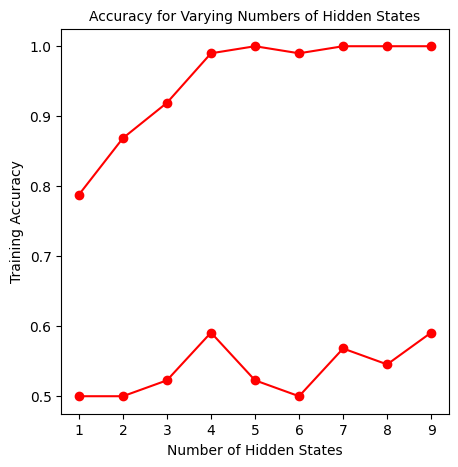

In [294]:
fig, axes = plt.subplots(1, 1, figsize=(5,5))
axes.set_title("Accuracy for Varying Numbers of Hidden States", fontsize=10)
axes.plot(hidden_states_set, accuracies_test, "-o", color='red')
axes.plot(hidden_states_set, accuracies_train, "-o", color='red')
axes.set_xticks(hidden_states_set)
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Training Accuracy")
plt.show()

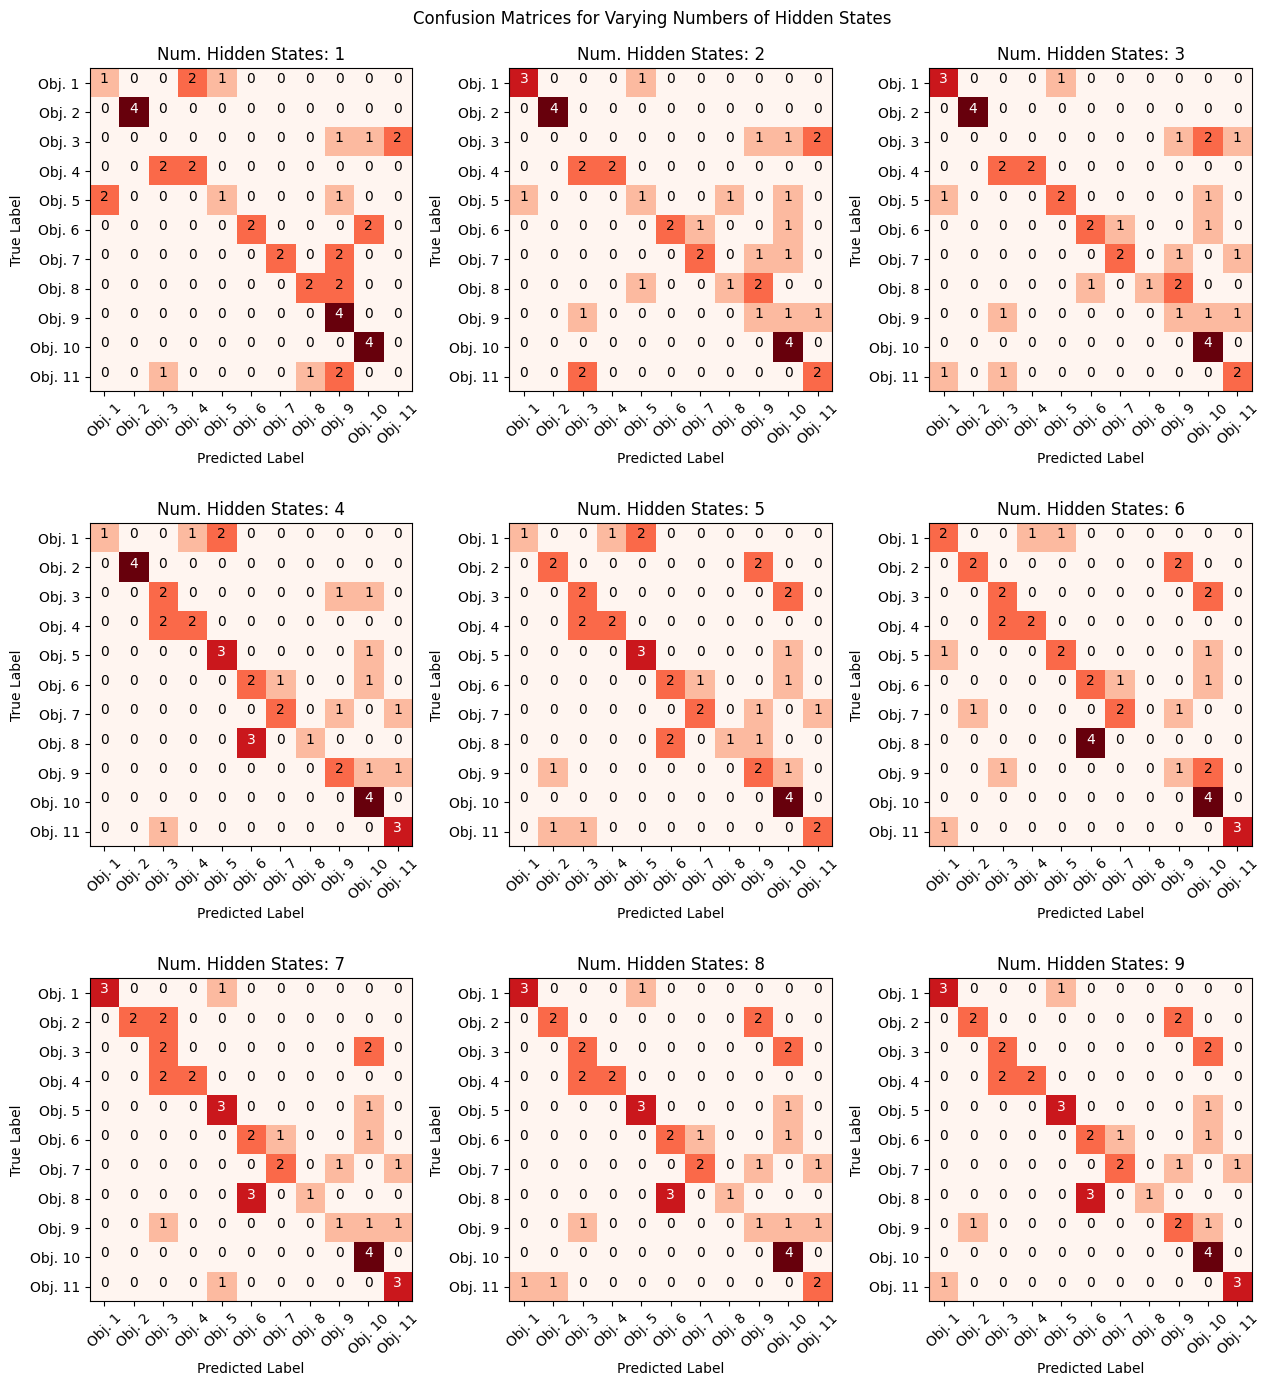

In [293]:
#generate confusion matrices
objects = 11
object_set = [i for i in range(1, objects + 1)]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.suptitle('Confusion Matrices for Varying Numbers of Hidden States')
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test[hidden_states], predicted_labels_all_test[hidden_states])
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, hidden_states=hidden_states, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

In [216]:
#analyze the effect of changing the starting seed
#define data extraction parameters
channel = 0
scaling = True

#define train/test split
run_total = 13
run_ideal_max = 8
run_real_max = 1

#model parameters
model_name = 'GaussianHMM'
cov_type = 'diag'
mfcc_features = 25
start_state_set = [i for i in range(0, 21)]

#initialize arrays
accuracies_train = {}
real_labels_all_train = {}
predicted_labels_all_train = {}
#------------------------------
accuracies_test = {}
real_labels_all_test = {}
predicted_labels_all_test = {}

train_data, test_data, train_lengths, test_lengths = data_extraction(channel=channel,
                                                                     mfcc_features=mfcc_features, 
                                                                     default_config=True, 
                                                                     run_ideal_max=run_ideal_max, 
                                                                     run_real_max=run_real_max, 
                                                                     scaling=scaling)
                                                                     
hidden_states_max = run_ideal_max + run_real_max
hidden_states_set = [i for i in range(1,hidden_states_max+1)]

for start_state in start_state_set:
    print(f'Starting Seed: {start_state}')
    accuracies_test[start_state] = []
    accuracies_train[start_state] = []
    for hidden_states in hidden_states_set:
        trained_models, conv_bool_set = model_training(hidden_states=hidden_states,
                                                    model_name=model_name,
                                                    cov_type=cov_type,
                                                    start_state=start_state,
                                                    train_data=train_data,
                                                    train_lengths=train_lengths)
        
        real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                    obs_per_object=run_ideal_max+run_real_max,
                                                    data=train_data,
                                                    lengths=train_lengths)
        
        real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                    obs_per_object=run_total-run_ideal_max-run_real_max,
                                                    data=test_data,
                                                    lengths=test_lengths)
        
        print(f'Number of Hidden States: {hidden_states} | Start Seed: {start_state}')
        print_convergence(conv_bool_set)
        
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracies_test[start_state].append(accuracy_test)
        real_labels_all_test[(start_state, hidden_states)] = real_labels_test
        predicted_labels_all_test[(start_state, hidden_states)] = predicted_labels_test

        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        accuracies_train[start_state].append(accuracy_train)
        real_labels_all_train[(start_state, hidden_states)] = real_labels_train
        predicted_labels_all_train[(start_state, hidden_states)] = predicted_labels_train

        

Number of Hidden States: 1 | Start Seed: 0
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2 | Start Seed: 0
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3 | Start Seed: 0
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4 | Start Seed: 0
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5 | Start Seed: 0
Object 1 : True| Object 2 : T

In [217]:
#compute average accuracy for each value of the number of hidden states across all starting seeds
average_accuracies_test = []
std_accuracies_test = []
#---------------------------
average_accuracies_train = []
std_accuracies_train = []

for hidx, hidden_states in enumerate(hidden_states_set):
    avg = 0
    std_array = []
    for start_state in start_state_set:
        avg += accuracies_test[start_state][hidx]
        std_array.append(accuracies_test[start_state][hidx])
    std_accuracies_test.append(statistics.stdev(std_array))
    average_accuracies_test.append(avg/len(start_state_set))

for hidx, hidden_states in enumerate(hidden_states_set):
    avg = 0
    std_array = []
    for start_state in start_state_set:
        avg += accuracies_train[start_state][hidx]
        std_array.append(accuracies_train[start_state][hidx])
    std_accuracies_train.append(statistics.stdev(std_array))
    average_accuracies_train.append(avg/len(start_state_set))

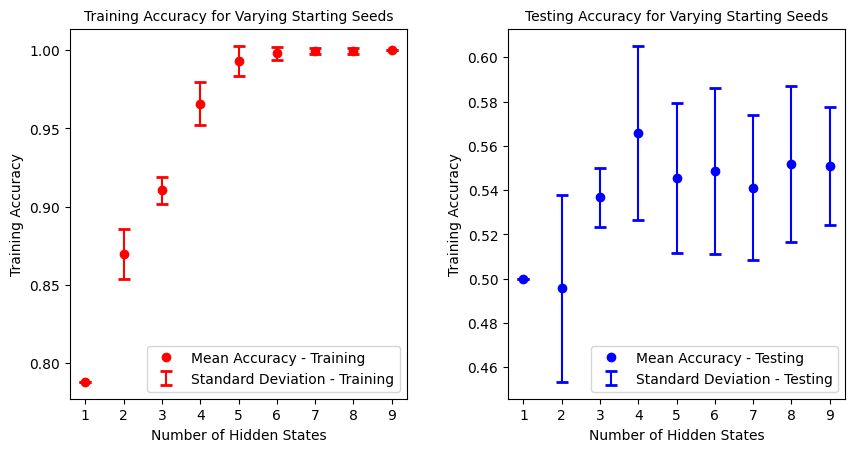

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes[0].set_title("Training Accuracy for Varying Starting Seeds", fontsize=10)
axes[1].set_title("Testing Accuracy for Varying Starting Seeds", fontsize=10)

axes[0].plot(hidden_states_set, average_accuracies_train, 'o', color='red', alpha=1, label='Mean Accuracy - Training')
axes[0].errorbar(hidden_states_set, average_accuracies_train, yerr=std_accuracies_train, fmt='none', ecolor='red', capsize=4, capthick=2, label='Standard Deviation - Training')

axes[1].plot(hidden_states_set, average_accuracies_test, 'o', color='blue', alpha=1, label='Mean Accuracy - Testing')
axes[1].errorbar(hidden_states_set, average_accuracies_test, yerr=std_accuracies_test, fmt='none', ecolor='blue', capsize=4, capthick=2, label='Standard Deviation - Testing')

axes[0].set_xticks(hidden_states_set)
axes[0].set_xlabel("Number of Hidden States")
axes[0].set_ylabel("Training Accuracy")
axes[0].legend()

axes[1].set_xticks(hidden_states_set)
axes[1].set_xlabel("Number of Hidden States")
axes[1].set_ylabel("Training Accuracy")
axes[1].legend()
plt.show()

In [233]:
#analyze the effect of changing the model type and the covariance type
#define data extraction parameters
channel = 0
scaling = True

#define train/test split
run_total = 13
run_ideal_max = 8
run_real_max = 1

#model parameters
model_name_set = 'GaussianHMM'
cov_type_set = ['diag','spherical','full','tied']
hidden_states_max = run_ideal_max + run_real_max
hidden_states_set = [i for i in range(1,hidden_states_max+1)]
mfcc_features = 25
start_state = 1

#initialize arrays
accuracies_test = {}
real_labels_all_test = {}
predicted_labels_all_test = {}
#------------------------
accuracies_train = {}
real_labels_all_train = {}
predicted_labels_all_train = {}

train_data, test_data, train_lengths, test_lengths = data_extraction(channel=channel,
                                                                     mfcc_features=mfcc_features, 
                                                                     default_config=True,
                                                                     run_ideal_max=run_ideal_max, 
                                                                     run_real_max=run_real_max, 
                                                                     scaling=scaling)
                                                                     
for cov_type in cov_type_set:
    print(f'Covariance Matrix Type: {cov_type}')
    accuracies_test[cov_type] = []
    accuracies_train[cov_type] = []
    for hidden_states in hidden_states_set:
        trained_models, conv_bool_set = model_training(hidden_states=hidden_states,
                                                    model_name=model_name,
                                                    cov_type=cov_type,
                                                    start_state=start_state,
                                                    train_data=train_data,
                                                    train_lengths=train_lengths)
        
        real_labels_train, predicted_labels_train = model_testing(trained_models=trained_models,
                                                    obs_per_object=run_ideal_max+run_real_max,
                                                    data=train_data,
                                                    lengths=train_lengths)
        
        real_labels_test, predicted_labels_test = model_testing(trained_models=trained_models,
                                                    obs_per_object=run_total-run_ideal_max-run_real_max,
                                                    data=test_data,
                                                    lengths=test_lengths)
        
        print(f'Number of Hidden States: {hidden_states}')
        print_convergence(conv_bool_set)
        
        accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
        accuracies_test[cov_type].append(accuracy_test)
        real_labels_all_test[(cov_type, hidden_states)] = real_labels_test
        predicted_labels_all_test[(cov_type, hidden_states)] = predicted_labels_test

        accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
        accuracies_train[cov_type].append(accuracy_train)
        real_labels_all_train[(cov_type, hidden_states)] = real_labels_train
        predicted_labels_all_train[(cov_type, hidden_states)] = predicted_labels_train

Number of Hidden States: 1
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 

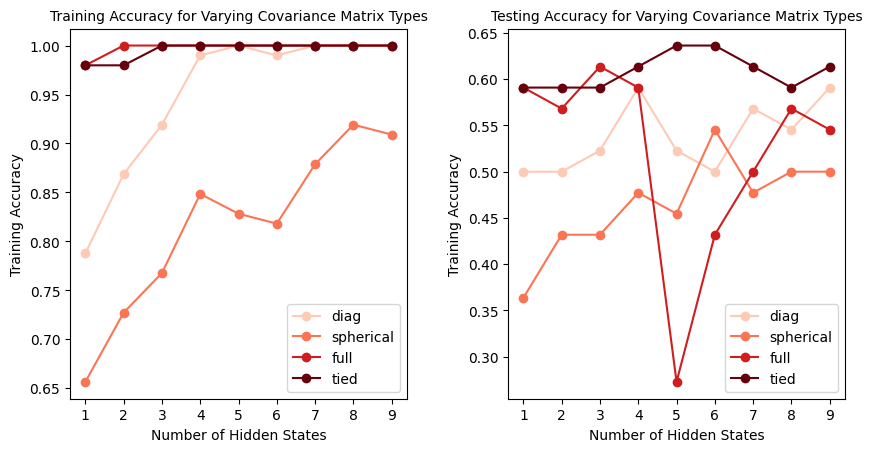

In [240]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
colormap = plt.colormaps['Reds']
color_offset = 0.2

axes[0].set_title("Training Accuracy for Varying Covariance Matrix Types", fontsize=10)
axes[1].set_title("Testing Accuracy for Varying Covariance Matrix Types", fontsize=10)

for cidx, cov_type in enumerate(cov_type_set):
    color_value = (cidx / (len(cov_type_set) - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)
    axes[0].plot(hidden_states_set, accuracies_train[cov_type], "-o", color=color, label=cov_type)

for cidx, cov_type in enumerate(cov_type_set):
    color_value = (cidx / (len(cov_type_set) - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)
    axes[1].plot(hidden_states_set, accuracies_test[cov_type], "-o", color=color, label=cov_type)

axes[0].set_xticks(hidden_states_set)
axes[1].set_xticks(hidden_states_set)

axes[0].set_xlabel("Number of Hidden States")
axes[0].set_ylabel("Training Accuracy")
axes[1].set_xlabel("Number of Hidden States")
axes[1].set_ylabel("Training Accuracy")

axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')

plt.show()

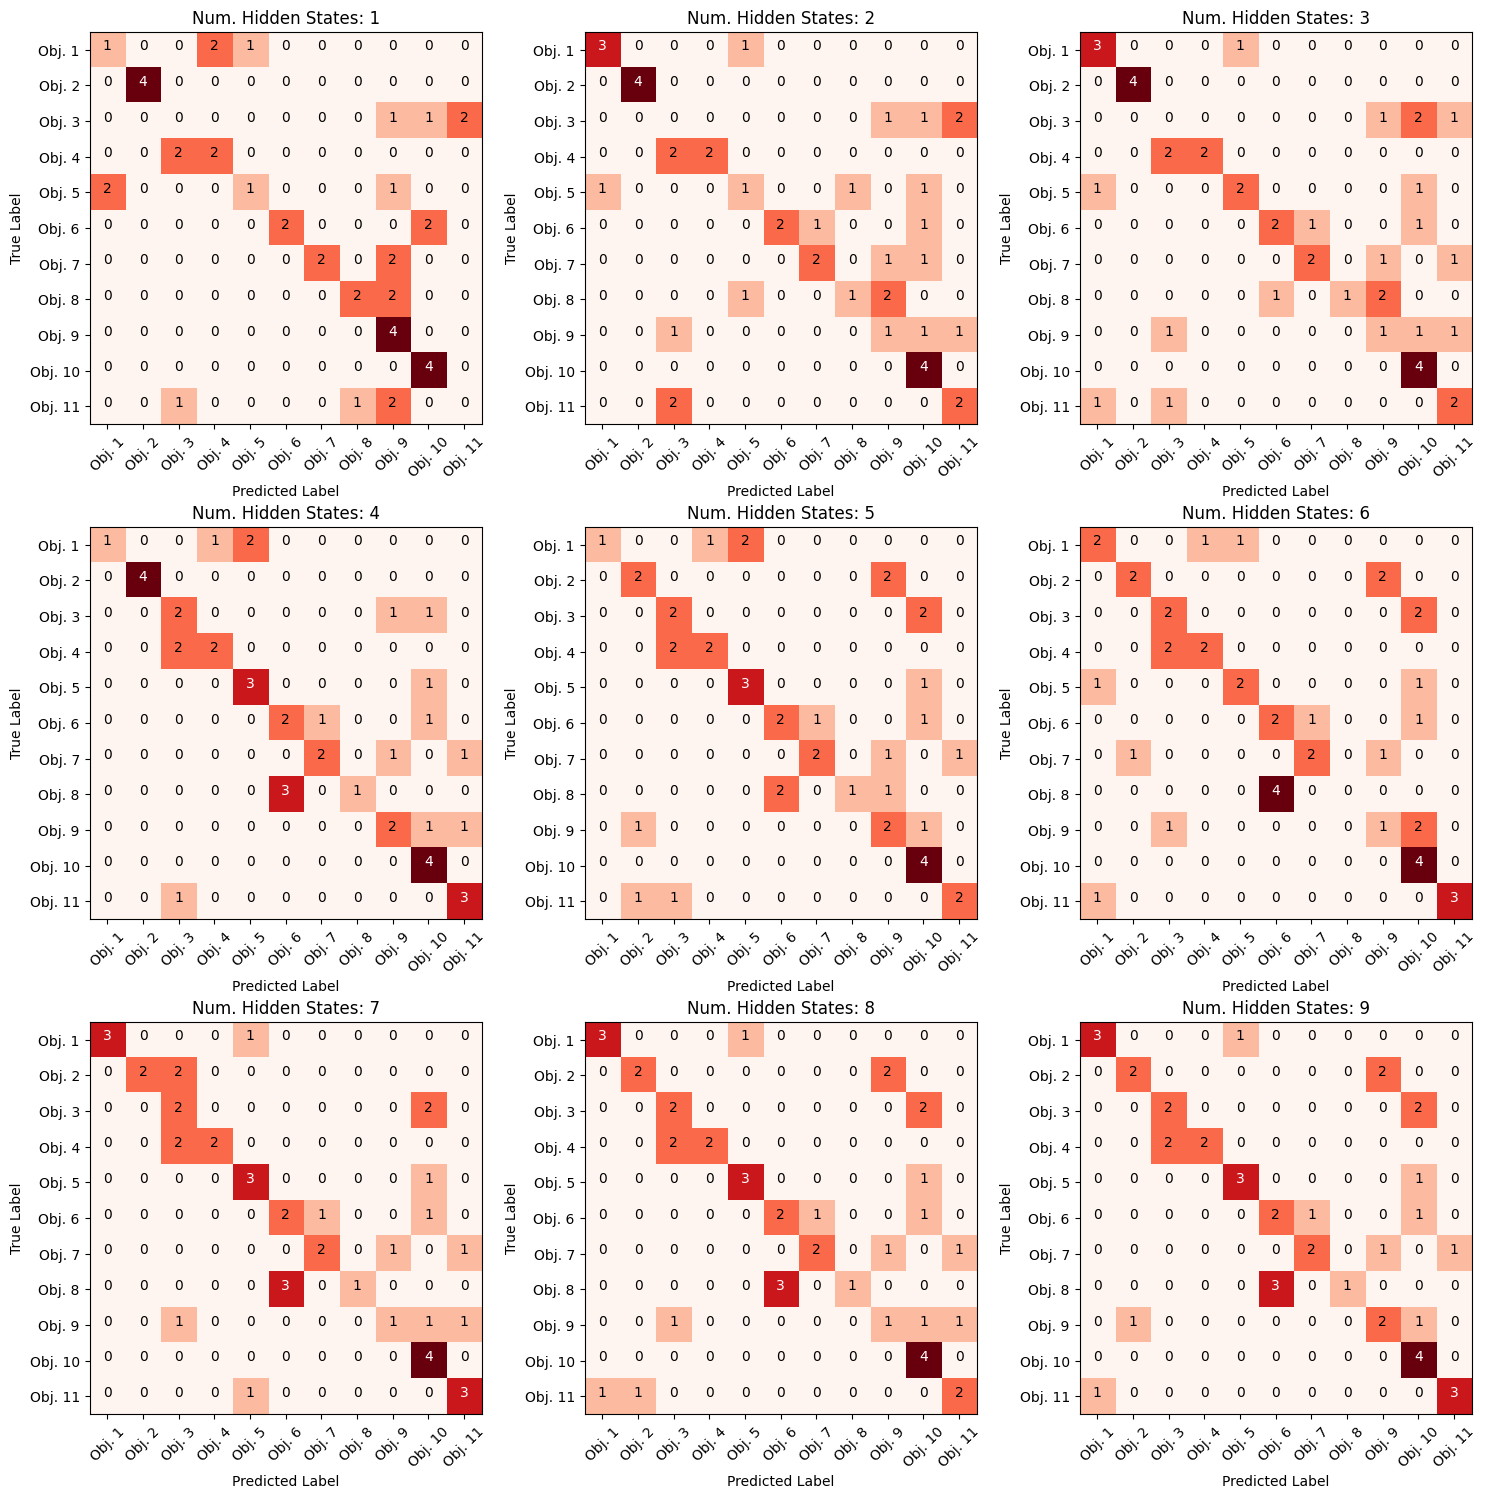

In [296]:
#generate the confusion matrices
objects = 11
cov_type = 'tied'
object_set = [i for i in range(1, objects + 1)]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.3, top=0.95, wspace=0.3)
fig.suptitle

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test[hidden_states], predicted_labels_all_test[hidden_states])
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, hidden_states=hidden_states, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()

### Textural Uniqueness
One consideration is that there are multiple object pairs in the dataset with the same texture but different colors. Since a purely acoustic-based classifier can not distinguish between colors, it is unlikely that it can correctly classify these object pairs. I will now modify the $\texttt{data\_extraction}(~)$ function to explicitly account for textural uniqueness. In other words, I consider objects with the same textures as being part of the same class.

In [242]:
def model_testing_new(trained_models, obs_per_object, data, lengths):
    #estimate the label of each time-series in the testing dataset
    #fixed parameters
    objects = 11
    object_set = [i for i in range(1, objects + 1)]
    
    #initialize arrays
    predicted_labels = []
    real_labels = []

    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, obs_per_object):
            obs_sequence = data[object_num - 1][obs_start_idx: obs_start_idx + lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub

            if object_num == 3:
                object_num_corr = 1
            elif object_num == 11:
                object_num_corr = 2
            elif object_num == 8:
                object_num_corr = 4
            elif object_num == 10:
                object_num_corr = 9
            else:
                object_num_corr = object_num
                
            if highest_likelihood_object == 3:
                highest_likelihood_object_corr = 1
            elif highest_likelihood_object == 11:
                highest_likelihood_object_corr = 2
            elif highest_likelihood_object == 8:
                highest_likelihood_object_corr = 4
            elif highest_likelihood_object == 10:
                highest_likelihood_object_corr = 9
            else:
                highest_likelihood_object_corr = highest_likelihood_object    

            real_labels.append(f'Obj. {object_num_corr}')
            predicted_labels.append(f'Obj. {highest_likelihood_object_corr}')
    
    return real_labels, predicted_labels

In [246]:
#analyze the affect of accounting for textural uniqueness
#define data extraction parameters
channel = 0
scaling = True

#define train/test split
run_total = 13
run_ideal_max = 8
run_real_max = 1

#model parameters
model_name = 'GaussianHMM'
cov_type = 'tied'
hidden_states_max = run_ideal_max + run_real_max
hidden_states_set = [i for i in range(1,hidden_states_max+1)]
mfcc_features = 25
start_state = 1

#initialize arrays
accuracies_train = []
real_labels_all_train = {}
predicted_labels_all_train = {}
#------------------------------
accuracies_test = []
real_labels_all_test = {}
predicted_labels_all_test = {}

train_data, test_data, train_lengths, test_lengths = data_extraction(channel=channel,
                                                                     mfcc_features=mfcc_features, 
                                                                     default_config=True,
                                                                     run_ideal_max=run_ideal_max, 
                                                                     run_real_max=run_real_max, 
                                                                     scaling=scaling)                                                                 

for hidden_states in hidden_states_set:
    trained_models, conv_bool_set = model_training(hidden_states=hidden_states,
                                                   model_name=model_name,
                                                   cov_type=cov_type,
                                                   start_state=start_state,
                                                   train_data=train_data,
                                                   train_lengths=train_lengths)
    
    real_labels_train, predicted_labels_train = model_testing_new(trained_models=trained_models,
                                                                  obs_per_object=run_ideal_max+run_real_max,
                                                                  data=train_data,
                                                                  lengths=train_lengths)
    
    real_labels_test, predicted_labels_test = model_testing_new(trained_models=trained_models,
                                                                obs_per_object=run_total-run_ideal_max-run_real_max,
                                                                data=test_data,
                                                                lengths=test_lengths)
    
    print(f'Number of Hidden States: {hidden_states}')
    print_convergence(conv_bool_set)
    
    accuracy_test = model_accuracy(real_labels_test, predicted_labels_test)
    accuracies_test.append(accuracy_test)
    real_labels_all_test[hidden_states] = real_labels_test
    predicted_labels_all_test[hidden_states] = predicted_labels_test

    accuracy_train = model_accuracy(real_labels_train, predicted_labels_train)
    accuracies_train.append(accuracy_train)
    real_labels_all_train[hidden_states] = real_labels_train
    predicted_labels_all_train[hidden_states] = predicted_labels_train

Number of Hidden States: 1
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 2
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 3
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 4
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 7 : True| Object 8 : True| Object 9 : True| Object 10: True| Object 11: True| 

Number of Hidden States: 5
Object 1 : True| Object 2 : True| Object 3 : True| Object 4 : True| Object 5 : True| Object 6 : True| Object 

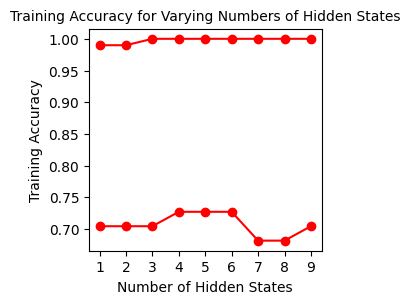

In [250]:
fig, axes = plt.subplots(1, 1, figsize=(3,3))
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
axes.set_title("Training Accuracy for Varying Numbers of Hidden States", fontsize=10)
axes.plot(hidden_states_set, accuracies_test, "-o", color='red')
axes.plot(hidden_states_set, accuracies_train, "-o", color='red')
axes.set_xticks(hidden_states_set)
axes.set_xlabel("Number of Hidden States")
axes.set_ylabel("Training Accuracy")
plt.show()

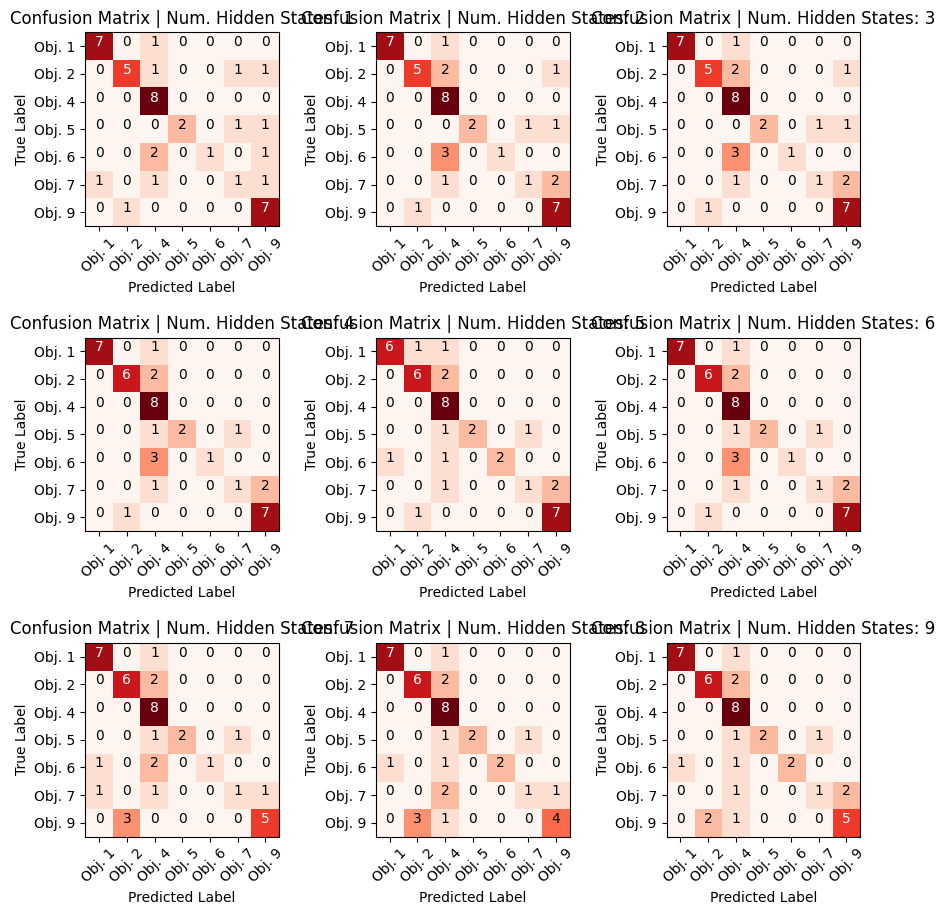

In [261]:
#generate the confusion matrices
objects = 11
cov_type = 'tied'
object_set = [1,2,4,5,6,7,9]
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(10, 4*num_rows))
fig.subplots_adjust(hspace=0.1, top=0.85, wspace=0.5)

for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels_all_test[hidden_states], predicted_labels_all_test[hidden_states])
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, hidden_states=hidden_states, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.show()

In [ ]:
#evaluate the accuracy of the training dataset
#estimate the label of each time-series in the testing dataset
object_set = [i for i in range(1, objects + 1)]
predicted_labels = [] 
real_labels = []

for hidden_states in hidden_states_set:
    predicted_labels_HS = []
    real_labels_HS = []
    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, run_ideal_total + run_real_total - run_ideal_max - run_real_max):
            obs_sequence = test_data[object_num - 1][obs_start_idx: obs_start_idx + test_lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += test_lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models_all[object_num_sub][hidden_states] #model
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
            real_labels_HS.append(f'Obj. {object_num}')
            predicted_labels_HS.append(f'Obj. {highest_likelihood_object}')
    
    real_labels.append(real_labels_HS)
    predicted_labels.append(predicted_labels_HS)

### A Note on Expected Variability in Results
[Source](https://stackoverflow.com/questions/39930895/why-i-get-different-values-everytime-i-run-the-function-hmmlearn-hmm-gaussianhmm)

In [313]:
#estimate the label of each time-series in the testing dataset
predicted_labels = [] 
real_labels = []

for hidden_states in hidden_states_set:
    predicted_labels_HS = []
    real_labels_HS = []
    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, run_ideal_total + run_real_total - run_ideal_max - run_real_max):
            obs_sequence = test_data[object_num - 1][obs_start_idx: obs_start_idx + test_lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += test_lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models_all[object_num_sub][hidden_states] #model
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
            real_labels_HS.append(f'Obj. {object_num}')
            predicted_labels_HS.append(f'Obj. {highest_likelihood_object}')
    
    real_labels.append(real_labels_HS)
    predicted_labels.append(predicted_labels_HS)

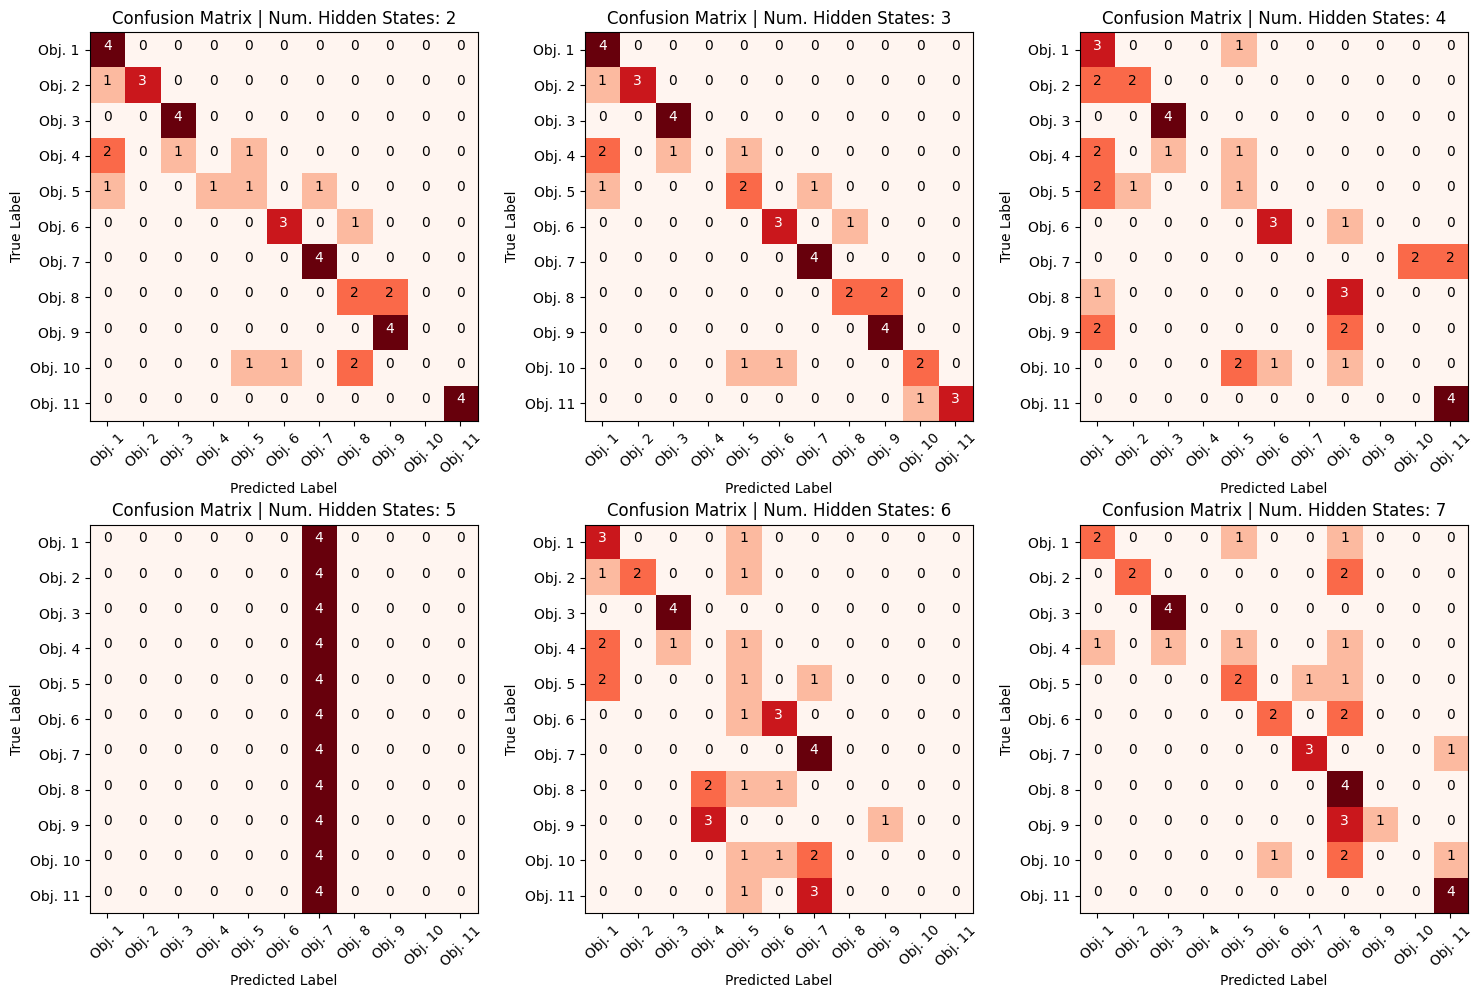

In [314]:
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))


fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))


for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels[hsidx], predicted_labels[hsidx])
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, hidden_states=hidden_states, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()

In [315]:
#compute performance metrics: accuracy
for hsidx, hidden_states in enumerate(hidden_states_set):
    accuracy = accuracy_score(real_labels[hsidx], predicted_labels[hsidx])
    print(f'Hidden States: {hidden_states} | Accuracy: {accuracy: .2f}')

Hidden States: 2 | Accuracy:  0.66
Hidden States: 3 | Accuracy:  0.70
Hidden States: 4 | Accuracy:  0.45
Hidden States: 5 | Accuracy:  0.09
Hidden States: 6 | Accuracy:  0.41
Hidden States: 7 | Accuracy:  0.55


In [316]:
#compute performance metrics
for hsidx, hidden_states in enumerate(hidden_states_set):
    precision, recall, f1, support = precision_recall_fscore_support(real_labels[hsidx], predicted_labels[hsidx], average='weighted', zero_division=1)
    print(f'Hidden States: {hidden_states: <2} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-Score: {f1:.2f} | Support: {support}')


Hidden States: 2  | Precision: 0.66 | Recall: 0.66 | F1-Score: 0.69 | Support: None
Hidden States: 3  | Precision: 0.76 | Recall: 0.70 | F1-Score: 0.67 | Support: None
Hidden States: 4  | Precision: 0.61 | Recall: 0.45 | F1-Score: 0.47 | Support: None
Hidden States: 5  | Precision: 0.92 | Recall: 0.09 | F1-Score: 0.02 | Support: None
Hidden States: 6  | Precision: 0.66 | Recall: 0.41 | F1-Score: 0.44 | Support: None
Hidden States: 7  | Precision: 0.75 | Recall: 0.55 | F1-Score: 0.50 | Support: None


In [284]:
#focus on the best performing number of hidden states
print('------Classification Report for 3 Hidden States---------------------------------------------------------------')
print(classification_report(real_labels[1], predicted_labels[1], target_names=classes))
print('------Classification Report for 4 Hidden States---------------------------------------------------------------')
print(classification_report(real_labels[2], predicted_labels[2], target_names=classes))

------Classification Report for 3 Hidden States---------------------------------------------------------------
              precision    recall  f1-score   support

      Obj. 1       1.00      0.75      0.86         4
      Obj. 2       1.00      1.00      1.00         4
      Obj. 3       0.25      0.25      0.25         4
      Obj. 4       1.00      0.50      0.67         4
      Obj. 5       0.75      0.75      0.75         4
      Obj. 6       0.50      0.75      0.60         4
      Obj. 7       1.00      0.50      0.67         4
      Obj. 8       1.00      0.25      0.40         4
      Obj. 9       0.33      0.25      0.29         4
     Obj. 10       0.44      1.00      0.62         4
     Obj. 11       0.50      0.75      0.60         4

    accuracy                           0.61        44
   macro avg       0.71      0.61      0.61        44
weighted avg       0.71      0.61      0.61        44

------Classification Report for 4 Hidden States-----------------------------

### Initial Analysis of Results
The previous cells show the accuracy of the classification tasks for different values of the number of hidden states. The accuracy is highest for four hidden states. My hypothesis is that a lower number of hidden states allows the model to correctly classify unseen time-series while a higher number of hidden states makes the model prone to over-fitting. One consideration is that there are multiple object pairs in the dataset with the same texture but different colors. Since a purely acoustic-based classifier can not distinguish between colors, it is unlikely that it can correctly classify these object pairs. In the next cells, I explicitly account for textural uniqueness. In other words, I consider objects with the same textures as being part of the same class.

In [317]:
#predict labels & take object textural uniqueness into account
#estimate the label of each time-series in the testing dataset
predicted_labels = [] 
real_labels = []

for hidden_states in hidden_states_set:
    predicted_labels_HS = []
    real_labels_HS = []
    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, run_ideal_total + run_real_total - run_ideal_max - run_real_max):
            obs_sequence = test_data[object_num - 1][obs_start_idx: obs_start_idx + test_lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += test_lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models_all[object_num_sub][hidden_states] #model
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub

            if object_num == 3:
                object_num_corr = 1
            elif object_num == 11:
                object_num_corr = 2
            elif object_num == 8:
                object_num_corr = 4
            elif object_num == 10:
                object_num_corr = 9
            else:
                object_num_corr = object_num
                
            if highest_likelihood_object == 3:
                highest_likelihood_object_corr = 1
            elif highest_likelihood_object == 11:
                highest_likelihood_object_corr = 2
            elif highest_likelihood_object == 8:
                highest_likelihood_object_corr = 4
            elif highest_likelihood_object == 10:
                highest_likelihood_object_corr = 9
            else:
                highest_likelihood_object_corr = highest_likelihood_object

            real_labels_HS.append(f'Obj. {object_num_corr}')
            predicted_labels_HS.append(f'Obj. {highest_likelihood_object_corr}')
    
    real_labels.append(real_labels_HS)
    predicted_labels.append(predicted_labels_HS)

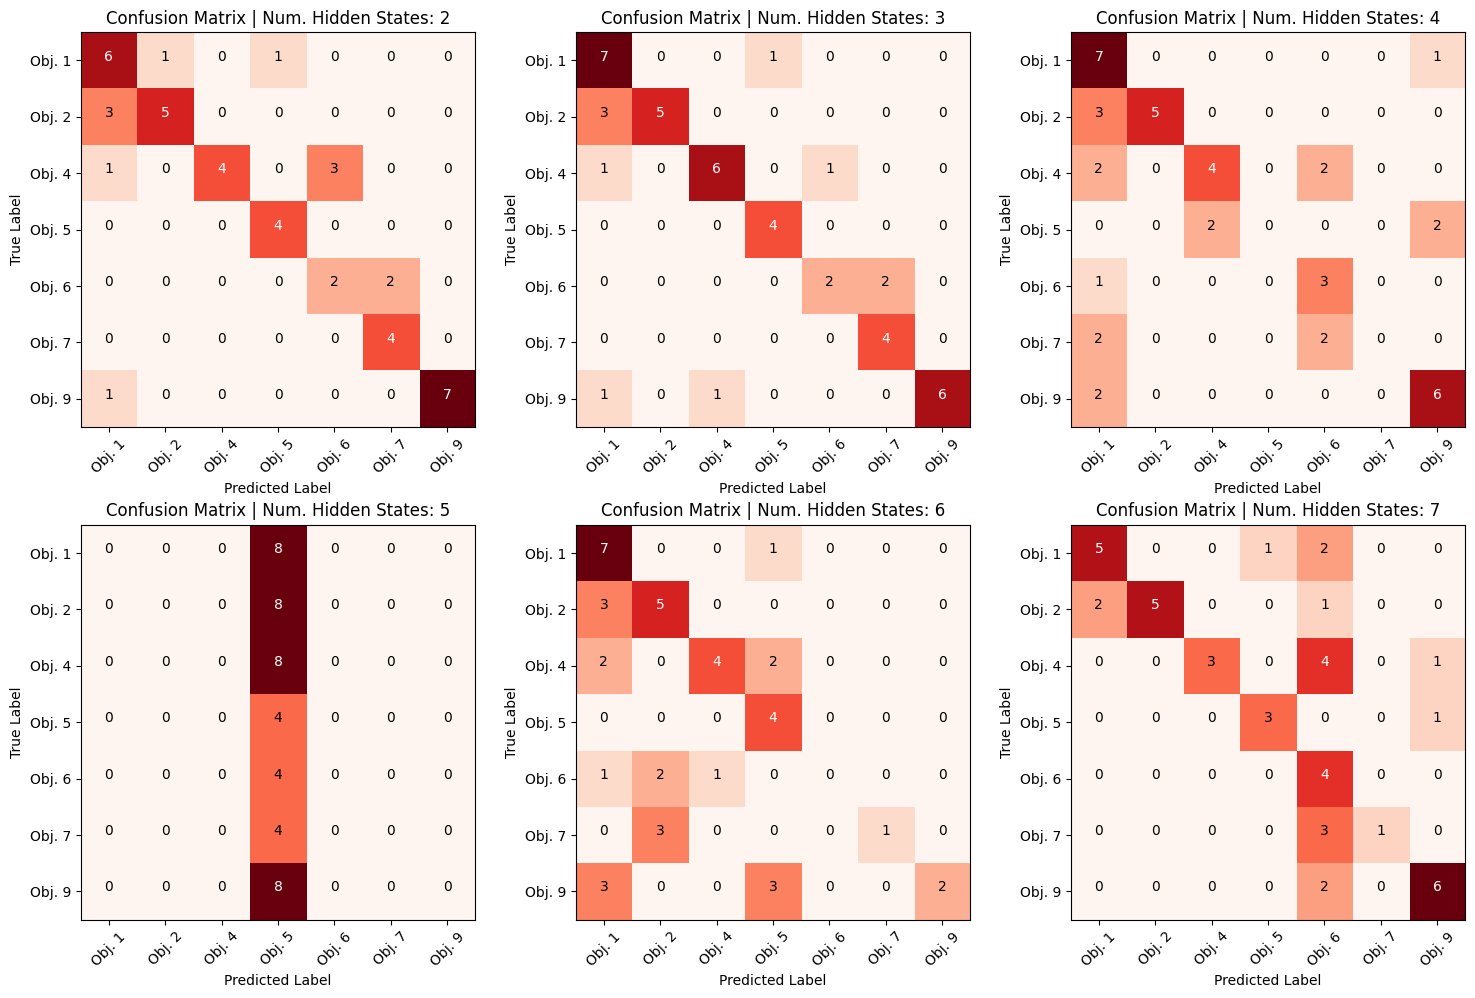

In [318]:
#plot the confusion matrices for different numbers of hidden states
unique_textures = [1,2,4,5,6,7,9]
classes = [f'Obj. {i}' for i in unique_textures]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))


fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))


for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels[hsidx], predicted_labels[hsidx])
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, hidden_states=hidden_states, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()

In [319]:
for hsidx, hidden_states in enumerate(hidden_states_set):
    accuracy = accuracy_score(real_labels[hsidx], predicted_labels[hsidx])
    print(f'Hidden States: {hidden_states} | Accuracy: {accuracy: .2f}')
print("\n")
for hsidx, hidden_states in enumerate(hidden_states_set):
    precision, recall, f1, support = precision_recall_fscore_support(real_labels[hsidx], predicted_labels[hsidx], average='weighted', zero_division=1)
    print(f'Hidden States: {hidden_states: <2} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-Score: {f1:.2f} | Support: {support}')

Hidden States: 2 | Accuracy:  0.73
Hidden States: 3 | Accuracy:  0.77
Hidden States: 4 | Accuracy:  0.57
Hidden States: 5 | Accuracy:  0.09
Hidden States: 6 | Accuracy:  0.52
Hidden States: 7 | Accuracy:  0.61


Hidden States: 2  | Precision: 0.78 | Recall: 0.73 | F1-Score: 0.73 | Support: None
Hidden States: 3  | Precision: 0.82 | Recall: 0.77 | F1-Score: 0.77 | Support: None
Hidden States: 4  | Precision: 0.72 | Recall: 0.57 | F1-Score: 0.52 | Support: None
Hidden States: 5  | Precision: 0.92 | Recall: 0.09 | F1-Score: 0.02 | Support: None
Hidden States: 6  | Precision: 0.72 | Recall: 0.52 | F1-Score: 0.48 | Support: None
Hidden States: 7  | Precision: 0.81 | Recall: 0.61 | F1-Score: 0.64 | Support: None


In [288]:
#focus on the best performing number of hidden states
print('------Classification Report for 3 Hidden States---------------------------------------------------------------')
print(classification_report(real_labels[1], predicted_labels[1], target_names=classes))
print('------Classification Report for 4 Hidden States---------------------------------------------------------------')
print(classification_report(real_labels[2], predicted_labels[2], target_names=classes))

------Classification Report for 3 Hidden States---------------------------------------------------------------
              precision    recall  f1-score   support

      Obj. 1       1.00      0.88      0.93         8
      Obj. 2       0.83      0.62      0.71         8
      Obj. 4       0.53      1.00      0.70         8
      Obj. 5       1.00      0.50      0.67         4
      Obj. 6       1.00      0.25      0.40         4
      Obj. 7       0.33      0.25      0.29         4
      Obj. 9       0.70      0.88      0.78         8

    accuracy                           0.70        44
   macro avg       0.77      0.62      0.64        44
weighted avg       0.77      0.70      0.69        44

------Classification Report for 4 Hidden States---------------------------------------------------------------
              precision    recall  f1-score   support

      Obj. 1       0.88      0.88      0.88         8
      Obj. 2       0.83      0.62      0.71         8
      Obj. 4      

As expected, accounting for textural uniqueness increases the accuracy of the classifier. In the remaining experiments documented in this notebook, textural uniqueness will be taken into account. Specifically, the following objects will be considered as part of the same textural classes:

| Objects | Description |
| :---: | :---: |
| 1, 3 | Foam Balls |
| 2, 11 | Mesh Loofahs |
| 9, 11 | Foam Block and Sphere |

### Further Optimization of the Algorithm
Two features of the algorithm that we have not experimented with are the number of MFCC components, the window-size/overlap/padding (used to compute the discrete Fourier tranform). In the previous set of results, I used default value for each of these parameters (except for the number of MFCC components which was informed by HMM applied to speech processing). Given our baseline model-in which the number of hidden states, the type of covariance matrix and the model type are fixed-we will now explore the effect of changing these parameters. 

In [297]:
#fixed parameters
channel =               0                   #microphone channel
objects =               11                  #number of objects in dataset
run_ideal_total =       10                  #total number of ideal runs
run_real_total =        3                   #total number of real runs
run_ideal_max =         8                   #number of ideal runs for training                 
run_real_max =          1                   #number of real runs for training

In [298]:
def data_extraction(mfcc_features, window_factor, padding_factor, hop_factor, scaling=True):
    #dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
    #training: extract data from ideal/real folders and convert to MFCC observation
    train_data =            np.array([])        #empty array for all training data
    test_data =             np.array([])        #empty array for all testing data
    train_lengths =         []                  #length of each series of observations (training datset)
    test_lengths =          []                  #length of each series of observations (testing dataset

    ##new parameters related window-size/overlap/zero-padding
    samples_per_run = 44100
    window_size_s = round(samples_per_run*window_factor)
    n_fft = window_size_s*padding_factor
    hop_length_s = round(window_size_s*hop_factor)

    for object_num in range(1, objects + 1):
        temp_train_lengths = []
        object_data = np.array([])
        for run_ideal_num in range(0, run_ideal_max):
            run_ideal_num += 10*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)

            temp_train_lengths.append(np.transpose(mfcc_output).shape[0])

            if run_ideal_num == 10*(object_num - 1):
                object_data = np.transpose(mfcc_output)
            else:
                object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)
                
        for run_real_num in range(0, run_real_max):
            run_real_num += 3*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)

            temp_train_lengths.append(np.transpose(mfcc_output).shape[0])

            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)

        train_lengths.append(temp_train_lengths)

        if object_num == 1:
            train_data = np.array([object_data])
        else:
            train_data = np.append(train_data, np.array([object_data]), axis=0)

    #testing: extract data from ideal/real folders and convert to MFCC observation
    for object_num in range(1, objects + 1):
        temp_test_lengths = []
        object_data = np.array([])
        for run_ideal_num in range(run_ideal_max, run_ideal_total):
            run_ideal_num += 10*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)
            
            temp_test_lengths.append(np.transpose(mfcc_output).shape[0])

            if run_ideal_num == run_ideal_max + 10*(object_num - 1):
                object_data = np.transpose(mfcc_output)
            else:
                object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)
        
        for run_real_num in range(run_real_max, run_real_total):
            run_real_num += 3*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)

            temp_test_lengths.append(np.transpose(mfcc_output).shape[0])

            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)

        test_lengths.append(temp_test_lengths)

        if object_num == 1:
            test_data = np.array([object_data])
        else:
            test_data = np.append(test_data, np.array([object_data]), axis=0)

    #check output dimensions
    #print("Training Data Size: " + str(train_data.shape))
    #print("Testing Data Size: " + str(test_data.shape)) 

    #print("Training Data Lengths Size: " + str(len(train_lengths)))
    #print("Testing Data Lengths Size: " + str(len(test_lengths)))

    return train_data, test_data, train_lengths, test_lengths

In [299]:
def model_training(hidden_states, start_state, train_data, train_lengths):
    #train the model using the training dataset
    model_name='GaussianHMM'
    cov_type='full'
    n_iter=1000
    trained_model=None
    
    object_set = [i for i in range(1, objects + 1)]

    trained_models = {}

    for object_num in object_set:
        trained_model = hmm_generation(model_name=model_name, start_state=start_state, hidden_states=hidden_states, cov_type=cov_type, n_iter=n_iter)
        trained_model.train(train_data[object_num - 1], train_lengths[object_num - 1])
        trained_model.observation_likelihood(train_data[object_num - 1], lengths=train_lengths[object_num - 1])
        trained_models[object_num] = trained_model
        trained_model = None
    
    return trained_models

def model_testing(trained_models, test_data, test_lengths):
    #estimate the label of each time-series in the testing dataset
    object_set = [i for i in range(1, objects + 1)]
    predicted_labels = []
    real_labels = []
    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, run_ideal_total + run_real_total - run_ideal_max - run_real_max):
            obs_sequence = test_data[object_num - 1][obs_start_idx: obs_start_idx + test_lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += test_lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
            
            if object_num == 3:
                object_num_corr = 1
            elif object_num == 11:
                object_num_corr = 2
            elif object_num == 8:
                object_num_corr = 4
            elif object_num == 10:
                object_num_corr = 9
            else:
                object_num_corr = object_num
                
            if highest_likelihood_object == 3:
                highest_likelihood_object_corr = 1
            elif highest_likelihood_object == 11:
                highest_likelihood_object_corr = 2
            elif highest_likelihood_object == 8:
                highest_likelihood_object_corr = 4
            elif highest_likelihood_object == 10:
                highest_likelihood_object_corr = 9
            else:
                highest_likelihood_object_corr = highest_likelihood_object

            real_labels.append(f'Obj. {object_num_corr}')
            predicted_labels.append(f'Obj. {highest_likelihood_object_corr}')
    
    return real_labels, predicted_labels

def model_accuracy(real_labels, predicted_labels):
    accuracy = accuracy_score(real_labels, predicted_labels)
    
    return accuracy

In [300]:
#parameter space
mfcc_features_set = [5, 10, 15, 25, 35, 45, 55]
window_fraction_set = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
hidden_states_set = [3,4]
hop_factor = 0.2
padding_factor = 2
n_iterations = 1
start_state = 1

In [301]:
def update_and_display(value):
    clear_output(wait=True)
    display(value)

def compute_accuracy_precision(hidden_states_set, mfcc_features_set, window_fraction_set, padding_factor, hop_factor, n_iterations, start_state):
    accuracy_matrices = []
    precision_matrices = []
    trained_model=None
    global_idx = 0
    for hidden_states in hidden_states_set:
        accuracy_matrix = np.zeros((len(mfcc_features_set), len(window_fraction_set)))
        precision_matrix = np.zeros((len(mfcc_features_set), len(window_fraction_set)))

        for mfcc_idx, mfcc_features in enumerate(mfcc_features_set):
            for window_idx, window_fraction in enumerate(window_fraction_set):
                accuracies = []
                precisions = []
                
                #update_and_display(f'Hidden States: {hidden_states} | MFCC Features: {mfcc_features} | Window Factor: {window_fraction}')
                
                for _ in range(n_iterations):
                    train_data, test_data, train_lengths, test_lengths = data_extraction(mfcc_features=mfcc_features, window_factor=window_fraction, padding_factor=padding_factor, hop_factor=hop_factor, scaling=True)
                    trained_model = model_training(hidden_states=hidden_states, start_state=start_state, train_data=train_data, train_lengths=train_lengths)
                    real_labels, predicted_labels = model_testing(trained_model, test_data, test_lengths)
                    accuracy = model_accuracy(real_labels, predicted_labels)
                    trained_model = None
                    # Ensure that labels are array-like
                    precision, recall, f1, support = precision_recall_fscore_support(real_labels, predicted_labels, average='weighted', zero_division=1)

                    accuracies.append(accuracy)
                    precisions.append(precision)
                    global_idx += 1
                    update_and_display(f'Number of iterations run: {global_idx}')

                accuracy_matrix[mfcc_idx, window_idx] = np.mean(accuracies)
                precision_matrix[mfcc_idx, window_idx] = np.mean(precisions)

        accuracy_matrices.append(accuracy_matrix)
        precision_matrices.append(precision_matrix)

    return accuracy_matrices, precision_matrices

In [302]:
#evalue the accuracy/precision matrices for the parameter space
total_iterations = len(hidden_states_set)*len(mfcc_features_set)*len(window_fraction_set)*n_iterations
print(f'Total number of iterations: {total_iterations}')
accuracy_matrices, precision_matrices = compute_accuracy_precision(hidden_states_set=hidden_states_set, mfcc_features_set=mfcc_features_set, window_fraction_set=window_fraction_set, padding_factor=padding_factor, hop_factor=hop_factor, n_iterations=n_iterations, start_state=start_state)

'Number of iterations run: 84'

In [303]:
#save the accuracy and precision matrices
np.save('accuracy_matrices_4.npy', accuracy_matrices)
np.save('precision_matrices_4.npy', precision_matrices)

In [304]:
accuracy_matrices = np.load('accuracy_matrices_4.npy')
precision_matrices = np.load('precision_matrices_4.npy')

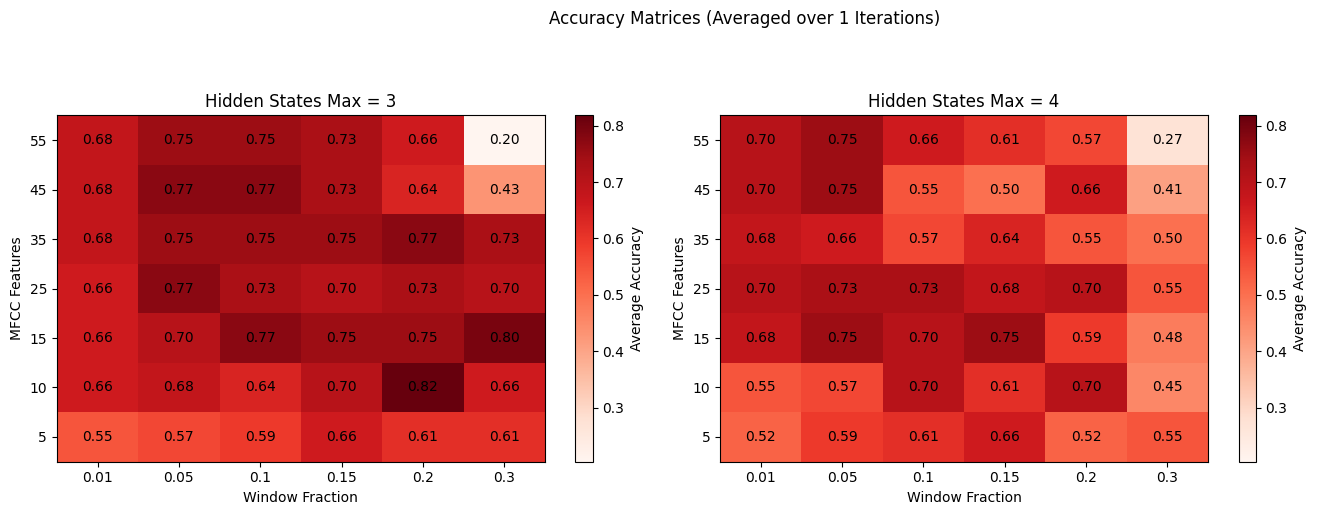

In [307]:
#accuracy matrices for different parameter combinations
# Calculate global minimum and maximum values across all matrices
global_min_acc = np.min([np.min(matrix) for matrix in accuracy_matrices])
global_max_acc = np.max([np.max(matrix) for matrix in accuracy_matrices])
global_min_prec = np.min([np.min(matrix) for matrix in precision_matrices])
global_max_prec = np.max([np.max(matrix) for matrix in precision_matrices])

# Plotting Accuracy Matrices
num_cols = 2
num_cols = min(num_cols, len(hidden_states_set))
num_rows = int(np.ceil(len(hidden_states_set) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle(f'Accuracy Matrices (Averaged over {n_iterations} Iterations)', y=1.02)

for hidden_states_max_idx, hidden_states_max in enumerate(hidden_states_set):
    accuracy_matrix = accuracy_matrices[hidden_states_max_idx]

    ax = axes.flatten()[hidden_states_max_idx]
    im = ax.pcolormesh(np.arange(len(window_fraction_set) + 1), np.arange(len(mfcc_features_set) + 1), accuracy_matrix, shading='auto', cmap='Reds', vmin=global_min_acc, vmax=global_max_acc)

    ax.set_xticks(np.arange(len(window_fraction_set)) + 0.5)
    ax.set_yticks(np.arange(len(mfcc_features_set)) + 0.5)

    ax.set_xticklabels([str(i) for i in window_fraction_set])
    ax.set_yticklabels([str(i) for i in mfcc_features_set])

    cbar = fig.colorbar(im, ax=ax, label='Average Accuracy')

    ax.set_xlabel('Window Fraction')
    ax.set_ylabel('MFCC Features')
    ax.set_title(f'Hidden States Max = {hidden_states_max}')

    # Add text annotations inside each box
    for i in range(len(window_fraction_set)):
        for j in range(len(mfcc_features_set)):
            text = f'{accuracy_matrix[j, i]:.2f}'
            ax.text(i + 0.5, j + 0.5, text, ha='center', va='center', color='black')

# Remove unused subplots
for i in range(len(hidden_states_set), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


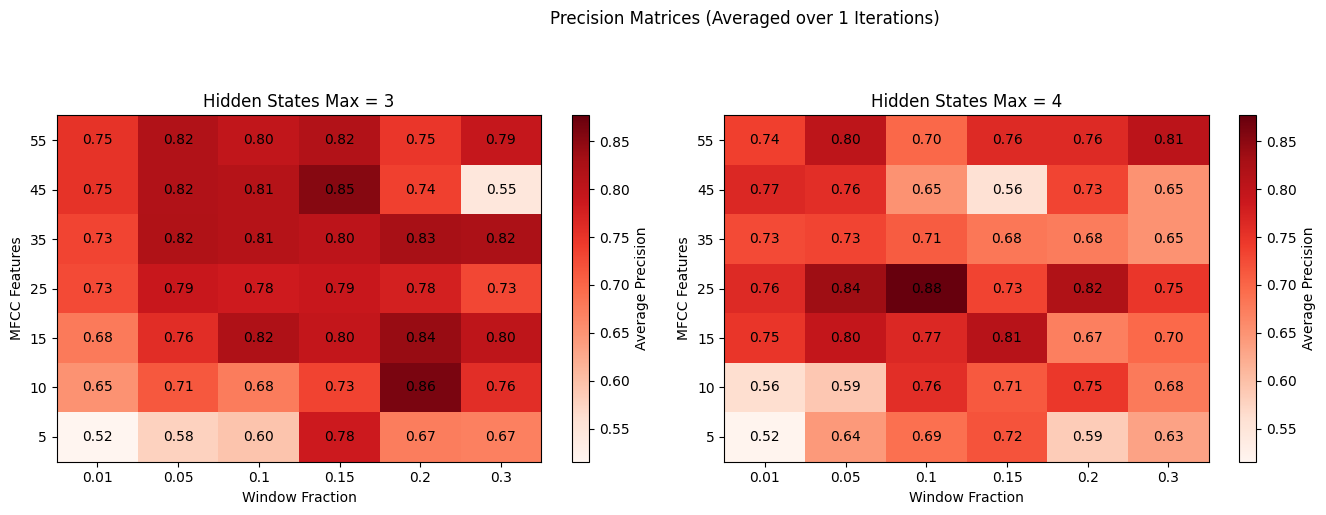

In [309]:
#precision matrices for different parameter combinations
# Calculate global minimum and maximum values across all matrices
global_min_prec = np.min([np.min(matrix) for matrix in precision_matrices])
global_max_prec = np.max([np.max(matrix) for matrix in precision_matrices])

# Plotting Precision Matrices
num_cols = min(num_cols, len(hidden_states_set))
num_rows = int(np.ceil(len(hidden_states_set) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle(f'Precision Matrices (Averaged over {n_iterations} Iterations)', y=1.02)

for hidden_states_max_idx, hidden_states_max in enumerate(hidden_states_set):
    precision_matrix = precision_matrices[hidden_states_max_idx]

    ax = axes.flatten()[hidden_states_max_idx]
    im = ax.pcolormesh(np.arange(len(window_fraction_set) + 1), np.arange(len(mfcc_features_set) + 1), precision_matrix, shading='auto', cmap='Reds', vmin=global_min_prec, vmax=global_max_prec)

    ax.set_xticks(np.arange(len(window_fraction_set)) + 0.5)
    ax.set_yticks(np.arange(len(mfcc_features_set)) + 0.5)

    ax.set_xticklabels([str(i) for i in window_fraction_set])
    ax.set_yticklabels([str(i) for i in mfcc_features_set])

    cbar = fig.colorbar(im, ax=ax, label='Average Precision')

    ax.set_xlabel('Window Fraction')
    ax.set_ylabel('MFCC Features')
    ax.set_title(f'Hidden States Max = {hidden_states_max}')

    # Add text annotations inside each box
    for i in range(len(window_fraction_set)):
        for j in range(len(mfcc_features_set)):
            text = f'{precision_matrix[j, i]:.2f}'
            ax.text(i + 0.5, j + 0.5, text, ha='center', va='center', color='black')

# Remove unused subplots
for i in range(len(hidden_states_set), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [308]:
#verify the results of the parameter search
mfcc_features = 10
hidden_states = 3
window_factor = 0.2
start_state = 1

train_data_op, test_data_op, train_lengths_op, test_lengths_op = data_extraction(mfcc_features=mfcc_features, window_factor=window_factor, padding_factor=2, hop_factor=0.2, scaling=True)
trained_models_op = model_training(start_state=start_state, hidden_states=hidden_states, train_data=train_data_op, train_lengths=train_lengths_op)
real_labels_op, predicted_labels_op = model_testing(trained_models_op, test_data_op, test_lengths_op)
accuracy_op = model_accuracy(real_labels_op, predicted_labels_op)
print(f'Accuracy of Model: {accuracy_op: .2f}')

Accuracy of Model:  0.82


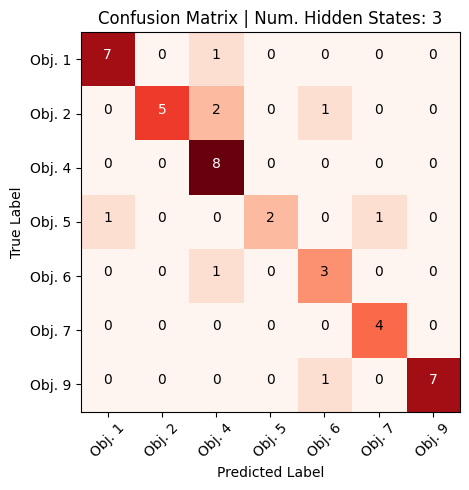

In [310]:
#plot the confusion matrix with the optimal parameters
unique_textures = [1,2,4,5,6,7,9]
classes = [f'Obj. {i}' for i in unique_textures]

num_hidden_states = 1
num_columns = 1
num_rows = int(np.ceil(num_hidden_states / num_columns))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))

row_idx = 1 // num_columns
col_idx = 1 % num_columns
cm = confusion_matrix(real_labels_op, predicted_labels_op)
plot_confusion_matrix(axes, cm, classes, hidden_states=hidden_states, normalize=False)

plt.tight_layout()
plt.show()

### Final Set of Experiments
Given the improved performance of the model, one may question how well it will perform with a smaller training dataset. The next set of experiment will attempt to answer this question.

In [178]:
#fixed parameters
channel =               0                   #microphone channel
objects =               11                  #number of objects in dataset
run_ideal_total =       10                  #total number of ideal runs
run_real_total =        3                   #total number of real runs

In [179]:
def data_extraction_2(mfcc_features, window_factor, padding_factor, hop_factor, run_ideal_max, run_real_max, scaling=True):
    #dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
    #training: extract data from ideal/real folders and convert to MFCC observation
    train_data =            np.array([])        #empty array for all training data
    test_data =             np.array([])        #empty array for all testing data
    train_lengths =         []                  #length of each series of observations (training datset)
    test_lengths =          []                  #length of each series of observations (testing dataset

    ##new parameters related window-size/overlap/zero-padding
    samples_per_run = 44100
    window_size_s = round(samples_per_run*window_factor)
    n_fft = window_size_s*padding_factor
    hop_length_s = round(window_size_s*hop_factor)

    for object_num in range(1, objects + 1):
        temp_train_lengths = []
        object_data = np.array([]).reshape(0, mfcc_features)
        for run_ideal_num in range(0, run_ideal_max):
            run_ideal_num += 10*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)

            temp_train_lengths.append(np.transpose(mfcc_output).shape[0])

            #if run_ideal_num == 10*(object_num - 1):
            #    object_data = np.transpose(mfcc_output)
            #else:
            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)
            
                
        for run_real_num in range(0, run_real_max):
            run_real_num += 3*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)

            temp_train_lengths.append(np.transpose(mfcc_output).shape[0])

            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)

        train_lengths.append(temp_train_lengths)

        if object_num == 1:
            train_data = np.array([object_data])
        else:
            train_data = np.append(train_data, np.array([object_data]), axis=0)

    #testing: extract data from ideal/real folders and convert to MFCC observation
    for object_num in range(1, objects + 1):
        temp_test_lengths = []
        object_data = object_data = np.array([]).reshape(0, mfcc_features)
        for run_ideal_num in range(run_ideal_max, run_ideal_total):
            run_ideal_num += 10*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
            #print(file_path)
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)
            
            temp_test_lengths.append(np.transpose(mfcc_output).shape[0])

            #if run_ideal_num == run_ideal_max + 10*(object_num - 1):
            #    object_data = np.transpose(mfcc_output)
            #else:
            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)
        
        for run_real_num in range(run_real_max, run_real_total):
            run_real_num += 3*(object_num - 1)
            file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
            #print(file_path)
            sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
            mfcc_output = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_features, n_fft=n_fft, hop_length=hop_length_s, win_length=window_size_s)

            temp_test_lengths.append(np.transpose(mfcc_output).shape[0])

            object_data = np.append(object_data, np.transpose(mfcc_output), axis=0)

        test_lengths.append(temp_test_lengths)

        if object_num == 1:
            test_data = np.array([object_data])
        else:
            test_data = np.append(test_data, np.array([object_data]), axis=0)

    #check output dimensions
    #print("Training Data Size: " + str(train_data.shape))
    #print("Testing Data Size: " + str(test_data.shape)) 

    #print("Training Data Lengths Size: " + str(len(train_lengths)))
    #print("Testing Data Lengths Size: " + str(len(test_lengths)))

    return train_data, test_data, train_lengths, test_lengths

In [180]:
def model_training_2(hidden_states, start_state, train_data, train_lengths):
    trained_model = None
    #train the model using the training dataset
    model_name='GaussianHMM'
    cov_type='full'
    n_iter=1000
    
    object_set = [i for i in range(1, objects + 1)]

    trained_models = {}
    trained_model = None

    for object_num in object_set:
        trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, cov_type=cov_type, n_iter=n_iter, start_state=start_state)
        trained_model.train(train_data[object_num - 1], train_lengths[object_num - 1])
        trained_model.observation_likelihood(train_data[object_num - 1], lengths=train_lengths[object_num - 1])
        trained_models[object_num] = trained_model
        trained_model = None
    
    return trained_models

def model_testing_2(trained_models, test_data, test_lengths):
    #estimate the label of each time-series in the testing dataset
    object_set = [i for i in range(1, objects + 1)]
    predicted_labels = []
    real_labels = []
    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, run_ideal_total + run_real_total - run_ideal_max - run_real_max):
            obs_sequence = test_data[object_num - 1][obs_start_idx: obs_start_idx + test_lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += test_lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models[object_num_sub]
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
            
            if object_num == 3:
                object_num_corr = 1
            elif object_num == 11:
                object_num_corr = 2
            elif object_num == 8:
                object_num_corr = 4
            elif object_num == 10:
                object_num_corr = 9
            else:
                object_num_corr = object_num
                
            if highest_likelihood_object == 3:
                highest_likelihood_object_corr = 1
            elif highest_likelihood_object == 11:
                highest_likelihood_object_corr = 2
            elif highest_likelihood_object == 8:
                highest_likelihood_object_corr = 4
            elif highest_likelihood_object == 10:
                highest_likelihood_object_corr = 9
            else:
                highest_likelihood_object_corr = highest_likelihood_object

            real_labels.append(f'Obj. {object_num_corr}')
            predicted_labels.append(f'Obj. {highest_likelihood_object_corr}')
    
    return real_labels, predicted_labels

def model_accuracy_2(real_labels, predicted_labels):
    accuracy = accuracy_score(real_labels, predicted_labels)
    
    return accuracy

In [217]:
#rts: reduced training set
#run_real_max = 1
#print(f'Train/Test Split: {train_percent: .2f}/{test_percent: .2f} | Accuracy: {accuracy_rts: .2f}')
total_runs = run_ideal_total + run_real_total
training_set_size = [i for i in range(4, 10)]
accuracies = []
train_percent = []

#params
mfcc_features=10
window_factor=0.2
padding_factor=2
hop_factor=0.2
hidden_states=3
start_state=1

for run_real_max in range(0, run_real_total + 1):
    accuracies_temp = []
    train_percent_temp = []
    for k in training_set_size:
        run_ideal_max = k - run_real_max
        train_percent_temp.append((run_real_max + run_ideal_max)/total_runs)
        train_data_rts, test_data_rts, train_lengths_rts, test_lengths_rts = data_extraction_2(mfcc_features=mfcc_features, window_factor=window_factor, padding_factor=padding_factor, hop_factor=hop_factor, scaling=True, run_ideal_max=run_ideal_max, run_real_max=run_real_max)
        trained_models_rts = model_training_2(hidden_states=hidden_states, start_state=start_state, train_data=train_data_rts, train_lengths=train_lengths_rts)
        real_labels_rts, predicted_labels_rts = model_testing_2(trained_models_rts, test_data_rts, test_lengths_rts)
        accuracy_rts = model_accuracy_2(real_labels_rts, predicted_labels_rts)
        accuracies_temp.append(accuracy_rts)
    train_percent.append(train_percent_temp)
    accuracies.append(accuracies_temp)

Model is not converging.  Current: -3542.984986405147 is not greater than -3494.252188385316. Delta is -48.73279801983108


(0.46515151515151515, 0.8681818181818183)

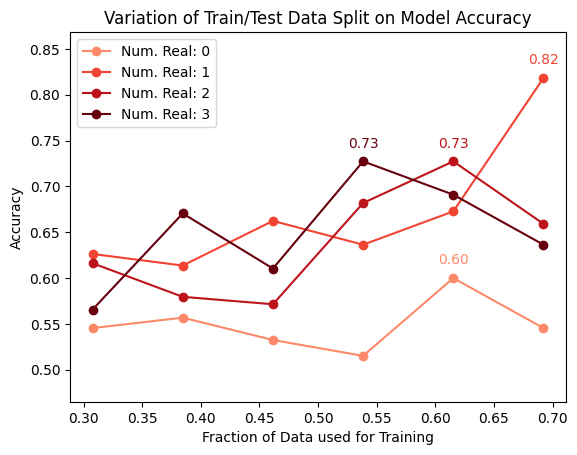

In [270]:
#generate plot for the accuracies as a function of the train/test data split
color_offset=0.4
norm = Normalize(vmin=0, vmax=1)
scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap='Reds')

# Plotting
for j in range(len(accuracies)):
    color = scalar_mappable.to_rgba((j / (len(accuracies) - 1)) * (1 - color_offset) + color_offset)
    plt.plot(train_percent[j], accuracies[j], 'o-', color=color, label=f'Num. Real: {j}')

    #for i, label in enumerate(accuracies[j]):
    #    plt.annotate('{:.2f}'.format(label), (train_percent[j][i], accuracies[j][i]),
    #                 textcoords="offset points", xytext=(0, 10), ha='center', color=color)
    max_accuracy = max(accuracies[j])
    max_accuracy_idx = [accuracies[j].index(max_accuracy)]
    for m in max_accuracy_idx:
        plt.annotate('{:.2f}'.format(max_accuracy), (train_percent[j][m], accuracies[j][m]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color=color)

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Fraction of Data used for Training')
plt.title('Variation of Train/Test Data Split on Model Accuracy')
plt.ylim(bottom=min(min(inner_list) for inner_list in accuracies)-0.05, top=max(max(inner_list) for inner_list in accuracies)+0.05) 